
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [2]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_1621037/989867417.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


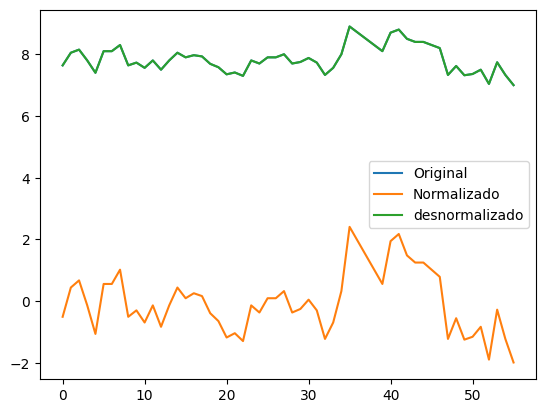

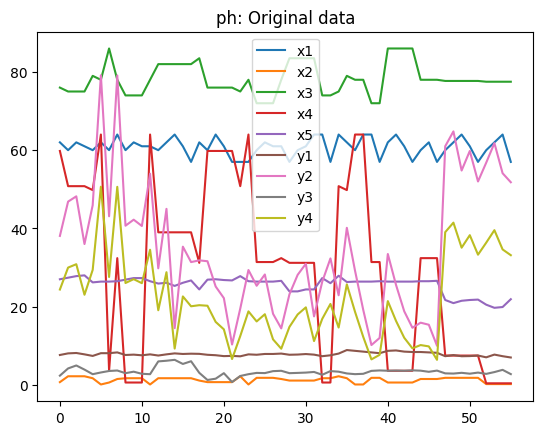

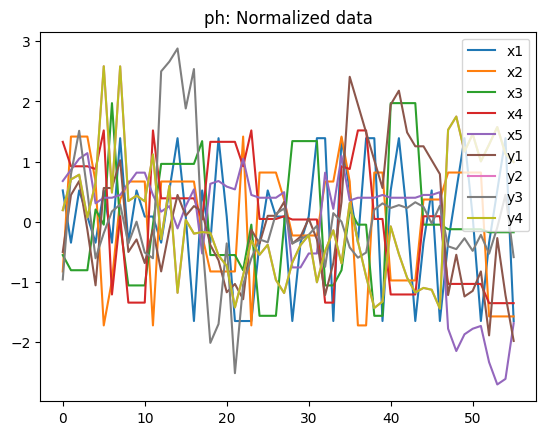

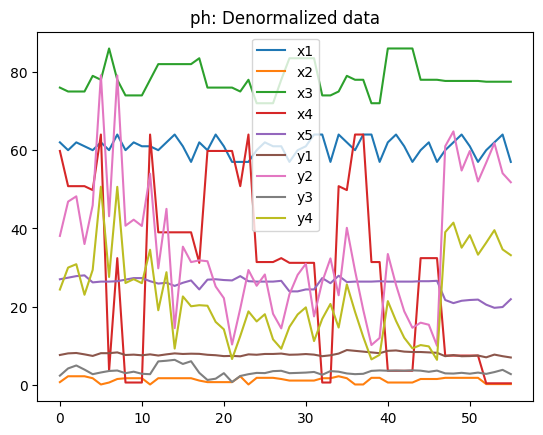

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y1"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y1")
test_out_scaler()
show_norm(label="ph")


In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-04-05 14:17:03.345128: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 14:17:03.376976: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 14:17:03.377021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 14:17:03.378121: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 14:17:03.383945: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 14:17:03.384975: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [6]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [7]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [8]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [9]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[15,10], [15,5], [15,7], [25,15], [25,5], [25, 7], [25, 10]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[15, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  1.244486774001416
Stopped at epoch:  15
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.2660622159983177
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.24112732499997946
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.29991571699974884
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.3693503739996231
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.18841317199985497
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 7 ++++++

Elapsed time:  0.3685993859999144
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Elapsed time:  0.25619789399934234
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Elapsed time:  0.30980891899889684
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Elapsed time:  0.26651428200057126
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_1] | 6 ++++++++++++++++++
Elapsed time:  0.31936183299876575
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [1_1] | 7 ++++++++++++++++++
Elapsed time:  0.3681403840000712
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_1] | 8 ++++++++++++++++++
Elapsed time:  0.24204762699991988
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_5_0,0.810281,0.935034,0.866392,0.906895,0.035492,0.009256,0.015286,0.012094
model_1_5_1,0.840542,0.924994,0.855485,0.896545,0.029831,0.010687,0.016534,0.013438
model_1_5_2,0.864086,0.914133,0.839890,0.883774,0.025426,0.012234,0.018318,0.015097
model_1_5_3,0.882348,0.902917,0.821800,0.869763,0.022010,0.013832,0.020388,0.016917
model_1_5_4,0.896454,0.891681,0.802590,0.855276,0.019371,0.015433,0.022586,0.018799
model_1_5_5,0.907284,0.880646,0.783117,0.840797,0.017345,0.017005,0.024814,0.020680
model_1_5_6,0.915535,0.869964,0.763916,0.826635,0.015802,0.018527,0.027011,0.022519
model_1_5_7,0.921754,0.859729,0.745325,0.812986,0.014638,0.019985,0.029138,0.024292
model_1_5_8,0.926377,0.850003,0.727550,0.799971,0.013773,0.021371,0.031171,0.025983
model_1_5_9,0.929748,0.840817,0.710716,0.787659,0.013143,0.022680,0.033097,0.027582


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Elapsed time:  0.3256932929998584
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Elapsed time:  0.37035401899993303
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Elapsed time:  0.31002572900069936
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Elapsed time:  0.2134253610001906
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Elapsed time:  0.22176191400103562
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Elapsed time:  0.29476912999962224
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Elapsed time:  0.36424108

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_6_0,0.942497,0.953274,0.962686,0.957820,0.010758,0.008969,0.007478,0.008268
model_1_6_1,0.950393,0.950355,0.962473,0.956203,0.009280,0.009530,0.007521,0.008585
model_1_6_2,0.956524,0.946626,0.962112,0.954097,0.008133,0.010246,0.007593,0.008998
model_1_6_3,0.961250,0.942361,0.961644,0.951661,0.007249,0.011064,0.007687,0.009475
model_1_6_4,0.964861,0.937781,0.961093,0.949021,0.006574,0.011944,0.007798,0.009993
model_1_6_5,0.967589,0.933061,0.960473,0.946276,0.006063,0.012849,0.007922,0.010531
model_1_6_6,0.969623,0.928340,0.959798,0.943503,0.005683,0.013756,0.008057,0.011074
model_1_6_7,0.971111,0.923721,0.959079,0.940762,0.005404,0.014642,0.008201,0.011611
model_1_6_24,0.972002,0.880143,0.948034,0.912854,0.005238,0.023007,0.010415,0.017082
model_1_6_8,0.972174,0.919278,0.958325,0.938096,0.005206,0.015495,0.008352,0.012134


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Elapsed time:  0.2379095469987078
Stopped at epoch:  7
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Elapsed time:  0.21043234600074356
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Elapsed time:  0.2540467449998687
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Elapsed time:  0.2683546610005578
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Elapsed time:  0.33223998900029983
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Elapsed time:  0.32915007900010096
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Elapsed time:  0.435246367

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_7_24,0.964236,0.823907,0.900666,0.869891,0.006691,0.023326,0.020496,0.021995
model_1_7_23,0.964694,0.826966,0.901472,0.871623,0.006605,0.022921,0.020330,0.021702
model_1_7_22,0.965196,0.830329,0.902363,0.873529,0.006511,0.022476,0.020146,0.021379
model_1_7_21,0.965745,0.834020,0.903346,0.875625,0.006408,0.021987,0.019943,0.021025
model_1_7_20,0.966344,0.838066,0.904431,0.877927,0.006296,0.021451,0.019719,0.020636
model_1_7_19,0.966996,0.842492,0.905628,0.880451,0.006174,0.020865,0.019472,0.020209
model_1_7_18,0.967705,0.847326,0.906946,0.883213,0.006042,0.020224,0.019200,0.019742
model_1_7_17,0.968472,0.852592,0.908394,0.886230,0.005898,0.019527,0.018902,0.019232
model_1_7_16,0.969298,0.858315,0.909985,0.889517,0.005744,0.018769,0.018573,0.018677
model_1_7_15,0.970186,0.864514,0.911728,0.893090,0.005578,0.017947,0.018214,0.018073


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Elapsed time:  1.0375958990007348
Stopped at epoch:  23
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Elapsed time:  0.37692348600103287
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Elapsed time:  0.318012006000572
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Elapsed time:  0.5481096629991953
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Elapsed time:  0.355099694999808
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Elapsed time:  0.2934910870008025
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Elapsed time:  0.385718519999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_8_0,0.976113,0.972578,0.907283,0.939864,0.004469,0.005036,0.025364,0.014602
model_1_8_1,0.976144,0.972550,0.907280,0.939851,0.004463,0.005041,0.025365,0.014605
model_1_8_24,0.976149,0.972119,0.906887,0.939470,0.004462,0.005120,0.025472,0.014697
model_1_8_23,0.976152,0.972126,0.906895,0.939477,0.004461,0.005119,0.025470,0.014696
model_1_8_22,0.976154,0.972133,0.906903,0.939484,0.004461,0.005117,0.025468,0.014694
model_1_8_21,0.976157,0.972141,0.906913,0.939493,0.004460,0.005116,0.025465,0.014692
model_1_8_20,0.976160,0.972150,0.906923,0.939502,0.004460,0.005114,0.025462,0.014690
model_1_8_19,0.976163,0.972160,0.906935,0.939511,0.004459,0.005112,0.025459,0.014687
model_1_8_18,0.976167,0.972171,0.906947,0.939522,0.004459,0.005110,0.025456,0.014685
model_1_8_2,0.976167,0.972520,0.907269,0.939833,0.004459,0.005046,0.025368,0.014609


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Elapsed time:  0.36776675100009015
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Elapsed time:  0.32653662799930316
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Elapsed time:  0.2402497669991135
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Elapsed time:  0.28177345100084494
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Elapsed time:  0.2924960109994572
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Elapsed time:  0.24385523199998715
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Elapsed time:  0.43175074

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_9_0,0.976913,0.944644,0.944535,0.945093,0.004319,0.016940,0.006264,0.011916
model_1_9_1,0.977486,0.944317,0.943905,0.944695,0.004212,0.017040,0.006335,0.012002
model_1_9_2,0.977909,0.943959,0.943207,0.944257,0.004133,0.017149,0.006414,0.012097
model_1_9_24,0.978189,0.939170,0.932804,0.938134,0.004080,0.018615,0.007589,0.013426
model_1_9_3,0.978215,0.943588,0.942473,0.943800,0.004075,0.017263,0.006497,0.012197
model_1_9_23,0.978219,0.939245,0.932983,0.938234,0.004075,0.018592,0.007569,0.013405
model_1_9_22,0.978251,0.939329,0.933180,0.938345,0.004069,0.018566,0.007546,0.013381
model_1_9_21,0.978285,0.939421,0.933398,0.938467,0.004062,0.018538,0.007522,0.013354
model_1_9_20,0.978322,0.939523,0.933637,0.938601,0.004055,0.018507,0.007495,0.013325
model_1_9_19,0.978361,0.939635,0.933899,0.938749,0.004048,0.018473,0.007465,0.013293


DataFrame salvo em ../results/metrics_1_9
Testando combinação 2: Hidden Size=[15, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Elapsed time:  1.0699716480012285
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Elapsed time:  0.3484246490006626
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Elapsed time:  0.24566286800109083
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Elapsed time:  0.4098232119995373
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Elapsed time:  0.3113508650003496
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Elapsed time:  0.36058497699923464
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_3_0,0.800066,0.487621,0.168830,0.400770,0.037403,0.115707,0.100955,0.108765
model_2_3_1,0.803528,0.491187,0.150541,0.397360,0.036756,0.114901,0.103176,0.109384
model_2_3_2,0.806145,0.494130,0.133640,0.393976,0.036266,0.114237,0.105229,0.109998
model_2_3_3,0.808091,0.496520,0.118076,0.390649,0.035902,0.113697,0.107119,0.110602
model_2_3_4,0.809502,0.498431,0.103774,0.387404,0.035638,0.113265,0.108856,0.111191
model_2_3_17,0.810145,0.503310,-0.001050,0.357607,0.035518,0.112164,0.121589,0.116599
model_2_3_16,0.810417,0.503432,0.003259,0.359045,0.035467,0.112136,0.121065,0.116338
model_2_3_5,0.810493,0.499934,0.090651,0.384261,0.035453,0.112926,0.110450,0.111761
model_2_3_15,0.810690,0.503537,0.008011,0.360610,0.035416,0.112112,0.120488,0.116054
model_2_3_14,0.810958,0.503612,0.013245,0.362309,0.035366,0.112095,0.119852,0.115746


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Elapsed time:  0.32583811199947377
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Elapsed time:  0.5152287490000163
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Elapsed time:  0.271511584000109
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Elapsed time:  0.2212978990010015
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Elapsed time:  0.20235258499997144
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Elapsed time:  0.2817062670001178
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Elapsed time:  0.33029613899

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_4_0,0.839157,0.888623,0.734612,0.838366,0.030090,0.014455,0.025334,0.019574
model_2_4_24,0.839486,0.718114,-0.760118,0.187164,0.030029,0.036583,0.168022,0.098437
model_2_4_23,0.840816,0.721832,-0.745048,0.194863,0.029780,0.036101,0.166584,0.097505
model_2_4_22,0.842270,0.725909,-0.728237,0.203412,0.029508,0.035572,0.164979,0.096469
model_2_4_21,0.843856,0.730372,-0.709472,0.212905,0.029211,0.034992,0.163188,0.095320
model_2_4_20,0.845582,0.735250,-0.688520,0.223444,0.028888,0.034359,0.161188,0.094043
model_2_4_19,0.847454,0.740568,-0.665120,0.235142,0.028538,0.033669,0.158954,0.092627
model_2_4_18,0.849478,0.746353,-0.638973,0.248123,0.028159,0.032918,0.156458,0.091055
model_2_4_17,0.851657,0.752630,-0.609749,0.262525,0.027752,0.032104,0.153668,0.089311
model_2_4_16,0.853991,0.759418,-0.577074,0.278497,0.027315,0.031223,0.150549,0.087376


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Elapsed time:  0.27739157600080944
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Elapsed time:  0.31480280599862454
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Elapsed time:  0.2373477509991062
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Elapsed time:  0.27448864899997716
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Elapsed time:  0.35189171099955274
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Elapsed time:  0.26814802199987753
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Elapsed time:  0.2861107

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_5_11,0.803374,0.784789,0.076911,0.457495,0.036784,0.047796,0.198844,0.118877
model_2_5_10,0.809751,0.804385,0.098245,0.477878,0.035591,0.043444,0.194248,0.114411
model_2_5_9,0.816257,0.824915,0.120517,0.499196,0.034374,0.038885,0.189450,0.109739
model_2_5_8,0.822777,0.846188,0.143531,0.521258,0.033154,0.034160,0.184493,0.104905
model_2_5_7,0.829155,0.867929,0.167023,0.543792,0.031961,0.029332,0.179432,0.099967
model_2_5_6,0.835193,0.889770,0.190646,0.566439,0.030832,0.024481,0.174344,0.095005
model_2_5_5,0.840640,0.911238,0.213979,0.588753,0.029813,0.019713,0.169318,0.090115
model_2_5_4,0.845197,0.931771,0.236524,0.610199,0.028960,0.015153,0.164461,0.085416
model_2_5_0,0.846372,0.990045,0.306503,0.673841,0.028740,0.002211,0.149387,0.071470
model_2_5_3,0.848507,0.950710,0.257720,0.630167,0.028341,0.010947,0.159895,0.081040


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Elapsed time:  0.3806424510003126
Stopped at epoch:  9
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Elapsed time:  0.3855267010003445
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Elapsed time:  0.3390259830011928
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Elapsed time:  0.4718664810006885
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Elapsed time:  0.4354354870010866
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Elapsed time:  0.45568560999890906
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Elapsed time:  0.35913396400

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_6_5,0.800941,0.071025,0.443307,0.327874,0.037239,0.102807,0.139666,0.120152
model_2_6_0,0.802396,0.158624,0.447490,0.359347,0.036967,0.093112,0.138617,0.114526
model_2_6_4,0.802637,0.092855,0.446370,0.337051,0.036922,0.100391,0.138898,0.118512
model_2_6_3,0.803820,0.113403,0.448576,0.345243,0.036701,0.098117,0.138344,0.117047
model_2_6_1,0.803892,0.147070,0.449395,0.356817,0.036687,0.094391,0.138139,0.114978
model_2_6_2,0.804303,0.131764,0.449672,0.351984,0.036610,0.096085,0.138070,0.115842


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Elapsed time:  1.3049801950000983
Stopped at epoch:  17
1/1 [==============================] - 0s 25ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Elapsed time:  0.4884261900006095
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Elapsed time:  0.26413319499988575
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Elapsed time:  0.24629683300008764
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Elapsed time:  0.3583674080000492
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Elapsed time:  0.28342616299960355
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Elapsed time:  0.44982257

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_7_0,0.945208,0.835173,0.537913,0.837240,0.010250,0.023411,0.027927,0.025536
model_2_7_24,0.946900,0.696311,0.654186,0.791766,0.009934,0.043134,0.020900,0.032671
model_2_7_23,0.947060,0.697979,0.653663,0.792471,0.009904,0.042897,0.020931,0.032560
model_2_7_1,0.947119,0.823157,0.556278,0.834811,0.009893,0.025117,0.026817,0.025917
model_2_7_22,0.947233,0.699825,0.653068,0.793248,0.009872,0.042634,0.020967,0.032438
model_2_7_21,0.947420,0.701865,0.652390,0.794102,0.009837,0.042345,0.021008,0.032304
model_2_7_20,0.947622,0.704120,0.651614,0.795043,0.009799,0.042024,0.021055,0.032156
model_2_7_19,0.947838,0.706610,0.650725,0.796075,0.009758,0.041671,0.021109,0.031995
model_2_7_18,0.948069,0.709359,0.649704,0.797207,0.009715,0.041280,0.021170,0.031817
model_2_7_17,0.948314,0.712388,0.648528,0.798446,0.009669,0.040850,0.021242,0.031623


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Elapsed time:  0.33591615200020897
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Elapsed time:  0.3231951579982706
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Elapsed time:  0.3166450319986325
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Elapsed time:  0.2600227309994807
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Elapsed time:  0.33373631600079534
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Elapsed time:  0.31402141400030814
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Elapsed time:  0.399394968

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_8_0,0.965191,0.894701,0.989985,0.951887,0.006512,0.015149,0.002384,0.009142
model_2_8_1,0.968893,0.896925,0.987952,0.951580,0.005819,0.014829,0.002868,0.009200
model_2_8_2,0.971771,0.898580,0.985756,0.950949,0.005281,0.014591,0.003391,0.009320
model_2_8_3,0.973990,0.899770,0.983463,0.950074,0.004866,0.014420,0.003936,0.009487
model_2_8_4,0.975687,0.900598,0.981140,0.949037,0.004548,0.014301,0.004489,0.009684
model_2_8_5,0.976973,0.901162,0.978850,0.947913,0.004308,0.014220,0.005034,0.009897
model_2_8_6,0.977941,0.901538,0.976643,0.946762,0.004127,0.014166,0.005560,0.010116
model_2_8_7,0.978664,0.901785,0.974552,0.945629,0.003992,0.014130,0.006057,0.010331
model_2_8_8,0.979196,0.901945,0.972596,0.944539,0.003892,0.014107,0.006523,0.010538
model_2_8_9,0.979582,0.902043,0.970780,0.943508,0.003820,0.014093,0.006955,0.010734


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Elapsed time:  0.2360848000007536
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Elapsed time:  0.25517238800057385
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Elapsed time:  0.21874100700006238
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Elapsed time:  0.2561156329993537
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Elapsed time:  0.4610823069997423
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Elapsed time:  0.25749869300125283
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Elapsed time:  0.254369532

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_9_24,0.980020,0.947298,0.907055,0.926992,0.003738,0.007016,0.018165,0.012263
model_2_9_23,0.980248,0.947987,0.908181,0.927898,0.003695,0.006925,0.017945,0.012111
model_2_9_22,0.980497,0.948747,0.909420,0.928895,0.003649,0.006824,0.017703,0.011943
model_2_9_21,0.980766,0.949582,0.910782,0.929992,0.003598,0.006712,0.017436,0.011759
model_2_9_20,0.981059,0.950499,0.912277,0.931195,0.003544,0.006590,0.017144,0.011557
model_2_9_19,0.981374,0.951504,0.913915,0.932514,0.003485,0.006456,0.016824,0.011335
model_2_9_18,0.981713,0.952605,0.915708,0.933957,0.003421,0.006310,0.016474,0.011093
model_2_9_17,0.982075,0.953807,0.917666,0.935533,0.003353,0.006150,0.016091,0.010828
model_2_9_0,0.982353,0.987984,0.976116,0.981880,0.003301,0.001600,0.004668,0.003044
model_2_9_16,0.982461,0.955118,0.919800,0.937252,0.003281,0.005975,0.015674,0.010539


DataFrame salvo em ../results/metrics_2_9
Testando combinação 3: Hidden Size=[15, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [3_0] | 1 ++++++++++++++++++
Elapsed time:  0.7391820800003188
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Elapsed time:  0.4574400399997103
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Elapsed time:  0.21334418500009633
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Elapsed time:  0.25856726900019567
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Elapsed time:  0.2075653970005078
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Elapsed time:  0.3357602340001904
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_2_0,0.802245,0.774203,0.345546,0.594870,0.036996,0.024495,0.130527,0.074392
model_3_2_1,0.814813,0.763991,0.337963,0.587800,0.034644,0.025603,0.132039,0.075691
model_3_2_2,0.823888,0.749281,0.328638,0.578434,0.032947,0.027199,0.133899,0.077411
model_3_2_23,0.824012,0.446004,0.187443,0.411409,0.032923,0.060100,0.162059,0.108081
model_3_2_22,0.824752,0.451459,0.189893,0.414368,0.032785,0.059508,0.161571,0.107537
model_3_2_21,0.825554,0.457509,0.192609,0.417648,0.032635,0.058852,0.161029,0.106935
model_3_2_20,0.826422,0.464215,0.195620,0.421285,0.032473,0.058124,0.160429,0.106267
model_3_2_19,0.827355,0.471644,0.198956,0.425313,0.032298,0.057318,0.159763,0.105528
model_3_2_18,0.828355,0.479872,0.202647,0.429773,0.032111,0.056426,0.159027,0.104709
model_3_2_17,0.829418,0.488974,0.206728,0.434706,0.031912,0.055438,0.158213,0.103803


DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Elapsed time:  0.3904705160002777
Stopped at epoch:  8
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Elapsed time:  0.2716821860012715
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Elapsed time:  0.236904860001232
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Elapsed time:  0.2845695539999724
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Elapsed time:  0.2499265899987222
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Elapsed time:  0.22615018199940096
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Elapsed time:  0.280976943000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_3_0,0.885451,0.783485,0.775317,0.791542,0.021430,0.042858,0.018744,0.031510
model_3_3_24,0.894561,0.525242,0.618438,0.571766,0.019725,0.093975,0.031832,0.064731
model_3_3_23,0.896015,0.531719,0.625445,0.578076,0.019453,0.092693,0.031247,0.063777
model_3_3_1,0.896510,0.774599,0.781891,0.787089,0.019361,0.044617,0.018196,0.032183
model_3_3_22,0.897602,0.538885,0.633050,0.585019,0.019156,0.091275,0.030613,0.062728
model_3_3_21,0.899330,0.546805,0.641269,0.592645,0.018833,0.089707,0.029927,0.061575
model_3_3_20,0.901204,0.555553,0.650109,0.601005,0.018482,0.087975,0.029190,0.060311
model_3_3_19,0.903229,0.565198,0.659556,0.610145,0.018104,0.086066,0.028402,0.058930
model_3_3_2,0.905037,0.765498,0.786233,0.781908,0.017765,0.046418,0.017834,0.032967
model_3_3_18,0.905401,0.575795,0.669568,0.620093,0.017697,0.083968,0.027566,0.057426


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Elapsed time:  0.211430551000376
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Elapsed time:  0.2227419259997987
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Elapsed time:  0.3139819970001554
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Elapsed time:  0.2967687089985702
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Elapsed time:  0.38652731200090784
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Elapsed time:  0.4428405790004035
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Elapsed time:  0.268257455998

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_4_0,0.905555,0.906148,0.164046,0.766079,0.017669,0.016812,0.040105,0.027773
model_3_4_1,0.914042,0.902254,0.155434,0.761331,0.016081,0.017509,0.040518,0.028337
model_3_4_2,0.920564,0.898313,0.142478,0.755720,0.014861,0.018215,0.041140,0.029003
model_3_4_3,0.925545,0.894443,0.126775,0.749643,0.013929,0.018908,0.041893,0.029725
model_3_4_4,0.929319,0.890717,0.109487,0.743379,0.013223,0.019576,0.042722,0.030468
model_3_4_5,0.932147,0.887176,0.091446,0.737121,0.012694,0.020210,0.043588,0.031211
model_3_4_6,0.934235,0.883843,0.073244,0.730997,0.012303,0.020807,0.044461,0.031938
model_3_4_24,0.935671,0.852747,-0.128844,0.667732,0.012035,0.026377,0.054156,0.039450
model_3_4_7,0.935744,0.880724,0.055288,0.725092,0.012021,0.021366,0.045323,0.032640
model_3_4_23,0.935900,0.853492,-0.123696,0.669307,0.011992,0.026244,0.053909,0.039263


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.6992581530012103
Stopped at epoch:  6
1/1 [==============================] - 0s 53ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.6647474439996586
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.35963083100068616
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.30910790400048427
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.402053916001023
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.26184067000031064
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.4293593069

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_0,0.941150,0.981507,0.566037,0.848232,0.011010,0.003266,0.041354,0.021190
model_3_5_1,0.945192,0.985009,0.550713,0.845655,0.010253,0.002647,0.042814,0.021549
model_3_5_24,0.946959,0.954181,0.368776,0.766576,0.009923,0.008091,0.060152,0.032590
model_3_5_23,0.947286,0.955140,0.371783,0.768184,0.009862,0.007921,0.059865,0.032365
model_3_5_22,0.947639,0.956187,0.375077,0.769943,0.009796,0.007736,0.059551,0.032120
model_3_5_21,0.948018,0.957327,0.378680,0.771864,0.009725,0.007535,0.059208,0.031852
model_3_5_2,0.948140,0.986819,0.535887,0.842105,0.009702,0.002327,0.044227,0.022045
model_3_5_20,0.948422,0.958566,0.382610,0.773956,0.009649,0.007316,0.058833,0.031560
model_3_5_19,0.948852,0.959909,0.386892,0.776230,0.009569,0.007079,0.058425,0.031242
model_3_5_18,0.949305,0.961358,0.391550,0.778697,0.009484,0.006823,0.057982,0.030898


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.40246963600111485
Stopped at epoch:  7
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.37766696400103683
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.32968536600128573
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.39904135600045265
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.3948762859999988
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.45135429999936605
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.2805058

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_24,0.960462,0.720888,0.948159,0.850276,0.007397,0.038896,0.007730,0.024230
model_3_6_23,0.960961,0.724794,0.948886,0.852373,0.007303,0.038351,0.007622,0.023890
model_3_6_22,0.961505,0.729111,0.949684,0.854687,0.007202,0.037750,0.007503,0.023516
model_3_6_21,0.962097,0.733879,0.950557,0.857239,0.007091,0.037085,0.007372,0.023103
model_3_6_20,0.962739,0.739143,0.951514,0.860053,0.006971,0.036352,0.007230,0.022647
model_3_6_19,0.963433,0.744948,0.952558,0.863153,0.006841,0.035543,0.007074,0.022146
model_3_6_0,0.963451,0.979931,0.993547,0.988053,0.006838,0.002797,0.000962,0.001933
model_3_6_18,0.964181,0.751346,0.953696,0.866563,0.006701,0.034651,0.006904,0.021594
model_3_6_17,0.964983,0.758391,0.954935,0.870312,0.006551,0.033670,0.006720,0.020987
model_3_6_16,0.965839,0.766142,0.956279,0.874429,0.006391,0.032589,0.006519,0.020321


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.36554513499868335
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.4081886889998714
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.44146126200030267
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.4134236760000931
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.3698077640001429
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.4543279040008201
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.3281353819

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_0,0.964535,0.864677,0.984362,0.932994,0.006635,0.014519,0.002245,0.008743
model_3_7_1,0.967568,0.855488,0.982735,0.928152,0.006067,0.015504,0.002479,0.009375
model_3_7_2,0.969791,0.846592,0.980544,0.923144,0.005651,0.016459,0.002793,0.010028
model_3_7_24,0.970320,0.756943,0.934845,0.860455,0.005552,0.026077,0.009355,0.018208
model_3_7_23,0.970503,0.758249,0.935700,0.861466,0.005518,0.025937,0.009232,0.018076
model_3_7_22,0.970700,0.759692,0.936642,0.862582,0.005481,0.025782,0.009097,0.017930
model_3_7_21,0.970912,0.761283,0.937678,0.863811,0.005442,0.025612,0.008948,0.017770
model_3_7_20,0.971140,0.763039,0.938816,0.865165,0.005399,0.025423,0.008784,0.017593
model_3_7_19,0.971382,0.764973,0.940065,0.866653,0.005354,0.025216,0.008605,0.017399
model_3_7_3,0.971385,0.838141,0.977954,0.918124,0.005353,0.017366,0.003165,0.010683


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.21764762200109544
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.22572262299945578
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.26315866299955815
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.2579808740010776
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.3012828709997848
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.20505858099932084
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.22199157

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.975115,0.977075,0.968843,0.973159,0.004655,0.001686,0.002645,0.002137
model_3_8_1,0.978645,0.974557,0.963002,0.968998,0.003995,0.001871,0.003141,0.002468
model_3_8_24,0.979890,0.908936,0.780647,0.845422,0.003762,0.006696,0.018622,0.012308
model_3_8_23,0.980142,0.910061,0.783934,0.847621,0.003715,0.006613,0.018343,0.012133
model_3_8_22,0.980415,0.911300,0.787553,0.850042,0.003664,0.006522,0.018035,0.011940
model_3_8_21,0.980710,0.912663,0.791530,0.852704,0.003609,0.006422,0.017698,0.011728
model_3_8_20,0.981027,0.914158,0.795898,0.855626,0.003549,0.006312,0.017327,0.011495
model_3_8_2,0.981190,0.971176,0.954785,0.963222,0.003519,0.002119,0.003838,0.002928
model_3_8_19,0.981366,0.915798,0.800687,0.858831,0.003486,0.006191,0.016920,0.011240
model_3_8_18,0.981727,0.917595,0.805929,0.862340,0.003419,0.006059,0.016475,0.010961


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.31084655099948577
Stopped at epoch:  8
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.26179435700032627
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.2016916400007176
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.22803337199911766
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.2106619670012151
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.19378391099962755
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.28214738

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_0,0.988412,0.992178,0.998336,0.995379,0.002168,0.001321,0.000299,0.000840
model_3_9_1,0.989917,0.988943,0.998453,0.993843,0.001886,0.001867,0.000278,0.001119
model_3_9_24,0.989928,0.938753,0.991818,0.966075,0.001884,0.010343,0.001470,0.006167
model_3_9_23,0.990045,0.939521,0.991966,0.966521,0.001862,0.010213,0.001443,0.006086
model_3_9_22,0.990172,0.940369,0.992128,0.967014,0.001839,0.010070,0.001414,0.005996
model_3_9_21,0.990309,0.941304,0.992306,0.967556,0.001813,0.009912,0.001382,0.005898
model_3_9_20,0.990457,0.942335,0.992500,0.968153,0.001785,0.009738,0.001347,0.005789
model_3_9_19,0.990615,0.943469,0.992712,0.968810,0.001756,0.009546,0.001309,0.005670
model_3_9_18,0.990785,0.944714,0.992943,0.969530,0.001724,0.009336,0.001268,0.005539
model_3_9_17,0.990964,0.946082,0.993194,0.970319,0.001690,0.009105,0.001223,0.005396


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[15, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.6082252479991439
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.3225729540008615
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.3097645519992511
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.362044847001016
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.3470172800007276
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.2966018150000309
Stopped at epoch:  6
1/1 [==============================] - 0s 17

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_2_7,0.800736,0.230254,0.555884,0.514279,0.037278,0.171490,0.059478,0.118778
model_4_2_6,0.801523,0.232171,0.575027,0.520137,0.037131,0.171063,0.056914,0.117346
model_4_2_0,0.801922,0.243201,0.761593,0.573538,0.037056,0.168606,0.031928,0.104287
model_4_2_5,0.802256,0.234179,0.597022,0.526774,0.036993,0.170615,0.053968,0.115723
model_4_2_4,0.802882,0.236249,0.622265,0.534278,0.036876,0.170154,0.050588,0.113888
model_4_2_1,0.803074,0.242009,0.720845,0.562462,0.036840,0.168871,0.037385,0.106995
model_4_2_3,0.803319,0.238320,0.651141,0.542719,0.036795,0.169693,0.046720,0.111824
model_4_2_2,0.803446,0.240296,0.683958,0.552129,0.036771,0.169253,0.042325,0.109522


DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Elapsed time:  0.2997102810004435
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Elapsed time:  0.21001329600039753
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Elapsed time:  0.2692496520012355
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Elapsed time:  0.2562682340012543
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Elapsed time:  0.3166220590010198
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Elapsed time:  0.2964823839993187
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Elapsed time:  0.29479690799

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_3_16,0.802542,0.082457,0.434559,0.349398,0.036940,0.157561,0.074348,0.118402
model_4_3_15,0.806403,0.096515,0.464836,0.366715,0.036218,0.155147,0.070367,0.115251
model_4_3_14,0.810481,0.112422,0.497502,0.385768,0.035455,0.152416,0.066071,0.111783
model_4_3_13,0.814749,0.130462,0.532568,0.406702,0.034656,0.149318,0.061461,0.107973
model_4_3_12,0.819163,0.150963,0.569967,0.429658,0.033831,0.145797,0.056543,0.103796
model_4_3_0,0.821150,0.851475,0.990761,0.922664,0.033459,0.025505,0.001215,0.014074
model_4_3_11,0.823656,0.174315,0.609530,0.454775,0.032990,0.141787,0.051341,0.099225
model_4_3_10,0.828131,0.200962,0.650958,0.482172,0.032153,0.137212,0.045894,0.094239
model_4_3_1,0.828581,0.730592,0.966095,0.853892,0.032069,0.046263,0.004458,0.026590
model_4_3_9,0.832452,0.231408,0.693801,0.511947,0.031345,0.131983,0.040261,0.088820


DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Elapsed time:  0.5272925709996343
Stopped at epoch:  10
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Elapsed time:  0.3385076239992486
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Elapsed time:  0.31400316799954453
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Elapsed time:  0.26016761800019594
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Elapsed time:  0.3689980809995177
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Elapsed time:  0.19632247499976074
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Elapsed time:  0.30037886

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_4_15,0.801192,0.635615,-0.192644,0.356169,0.037193,0.079985,0.167982,0.121395
model_4_4_14,0.803767,0.642550,-0.176896,0.365980,0.036711,0.078462,0.165764,0.119545
model_4_4_13,0.806554,0.650283,-0.159644,0.376811,0.036189,0.076765,0.163334,0.117503
model_4_4_12,0.809556,0.658895,-0.140798,0.388743,0.035628,0.074875,0.160680,0.115253
model_4_4_11,0.812768,0.668470,-0.120273,0.401860,0.035027,0.072773,0.157789,0.112780
model_4_4_10,0.816178,0.679096,-0.098009,0.416235,0.034389,0.070440,0.154653,0.110070
model_4_4_9,0.819762,0.690855,-0.073977,0.431930,0.033719,0.067859,0.151268,0.107110
model_4_4_8,0.823477,0.703826,-0.048195,0.448988,0.033024,0.065012,0.147637,0.103894
model_4_4_7,0.827262,0.718076,-0.020748,0.467419,0.032315,0.061884,0.143771,0.100419
model_4_4_6,0.831024,0.733657,0.008175,0.487189,0.031612,0.058464,0.139697,0.096691


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Elapsed time:  0.25588421799875505
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Elapsed time:  0.20000307800000883
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Elapsed time:  0.2143820239998604
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Elapsed time:  0.23744575000091572
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Elapsed time:  0.26275171499946737
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Elapsed time:  0.28835610799978895
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Elapsed time:  0.3269714

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_0,0.819204,0.514567,0.838200,0.666123,0.033823,0.055761,0.017806,0.037900
model_4_5_1,0.845031,0.552520,0.829645,0.682552,0.028991,0.051402,0.018748,0.036035
model_4_5_2,0.864957,0.577867,0.817511,0.690596,0.025263,0.048490,0.020083,0.035122
model_4_5_3,0.880232,0.593961,0.802873,0.692540,0.022406,0.046641,0.021694,0.034901
model_4_5_4,0.891869,0.603470,0.786671,0.690242,0.020229,0.045549,0.023477,0.035162
model_4_5_5,0.900671,0.608368,0.769635,0.685094,0.018582,0.044986,0.025352,0.035747
model_4_5_6,0.907262,0.610043,0.752288,0.678077,0.017349,0.044794,0.027261,0.036543
model_4_5_7,0.912126,0.609456,0.735000,0.669875,0.016439,0.044861,0.029163,0.037474
model_4_5_24,0.915603,0.540452,0.544269,0.545892,0.015789,0.052788,0.050153,0.051548
model_4_5_8,0.915642,0.607279,0.718028,0.660966,0.015781,0.045112,0.031031,0.038485


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.2694804620005016
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.34877030099960393
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.24346468299881963
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.3317101979992003
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.5421069390013145
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.5147938570007682
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.3056825650

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_24,0.916041,0.534638,0.714002,0.639257,0.015707,0.053558,0.049449,0.051624
model_4_6_23,0.916673,0.536732,0.717558,0.642170,0.015589,0.053317,0.048834,0.051207
model_4_6_22,0.917364,0.539050,0.721471,0.645383,0.015459,0.053050,0.048157,0.050748
model_4_6_21,0.918119,0.541617,0.725775,0.648922,0.015318,0.052755,0.047413,0.050241
model_4_6_20,0.918940,0.544457,0.730500,0.652818,0.015164,0.052428,0.046596,0.049684
model_4_6_19,0.919832,0.547594,0.735681,0.657099,0.014998,0.052067,0.045700,0.049071
model_4_6_18,0.920796,0.551056,0.741353,0.661798,0.014817,0.051669,0.044720,0.048398
model_4_6_17,0.921836,0.554872,0.747550,0.666947,0.014623,0.051229,0.043648,0.047662
model_4_6_16,0.922950,0.559070,0.754308,0.672576,0.014414,0.050746,0.042480,0.046856
model_4_6_0,0.923161,0.624735,0.923515,0.796738,0.014375,0.043189,0.013224,0.029088


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.47702355299952615
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.5857177910002065
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.24245021699971403
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.4772399449993827
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.2078762410001218
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.3132048669995129
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.1857818759

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_0,0.940098,0.995709,0.757770,0.938891,0.011206,0.001016,0.023117,0.011417
model_4_7_1,0.948227,0.993078,0.768940,0.939811,0.009686,0.001639,0.022051,0.011245
model_4_7_2,0.954536,0.990147,0.776471,0.939655,0.008505,0.002333,0.021333,0.011274
model_4_7_3,0.959430,0.987096,0.781479,0.938812,0.007590,0.003055,0.020855,0.011431
model_4_7_4,0.963220,0.984050,0.784724,0.937549,0.006881,0.003776,0.020545,0.011667
model_4_7_5,0.966147,0.981091,0.786738,0.936048,0.006333,0.004477,0.020353,0.011948
model_4_7_6,0.968400,0.978273,0.787894,0.934435,0.005912,0.005144,0.020243,0.012249
model_4_7_7,0.970124,0.975625,0.788455,0.932794,0.005589,0.005771,0.020189,0.012556
model_4_7_8,0.971436,0.973165,0.788610,0.931180,0.005344,0.006353,0.020174,0.012857
model_4_7_9,0.972426,0.970897,0.788492,0.929630,0.005158,0.006890,0.020185,0.013147


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.28892695299873594
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.19414903400138428
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.2676620460006234
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.25298958199891786
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.27056994799932
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.25665714199931244
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.3103952810

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_0,0.978078,0.848333,0.999775,0.972731,0.004101,0.009190,0.000068,0.004898
model_4_8_1,0.980752,0.850585,0.999241,0.972708,0.003601,0.009054,0.000231,0.004902
model_4_8_2,0.982714,0.850446,0.998404,0.972017,0.003234,0.009062,0.000485,0.005026
model_4_8_3,0.984134,0.848768,0.997368,0.970892,0.002968,0.009164,0.000800,0.005228
model_4_8_24,0.984627,0.795964,0.979895,0.947552,0.002876,0.012364,0.006108,0.009420
model_4_8_23,0.984744,0.797074,0.980238,0.948023,0.002854,0.012296,0.006004,0.009335
model_4_8_22,0.984870,0.798295,0.980615,0.948542,0.002831,0.012222,0.005889,0.009242
model_4_8_21,0.985005,0.799639,0.981031,0.949113,0.002805,0.012141,0.005763,0.009139
model_4_8_4,0.985139,0.846129,0.996209,0.969498,0.002780,0.009324,0.001152,0.005478
model_4_8_20,0.985149,0.801114,0.981487,0.949740,0.002778,0.012052,0.005624,0.009027


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.2352445880005689
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.2623012349995406
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.4145529759989586
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.3097404749987618
Stopped at epoch:  6
1/1 [==============================] - 0s 47ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.39954868399945553
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.20192441700055497
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.1971531460

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_0,0.987367,0.993177,0.993874,0.993572,0.002363,0.000852,0.001000,0.000922
model_4_9_1,0.989446,0.992762,0.994021,0.993458,0.001974,0.000904,0.000976,0.000938
model_4_9_2,0.991005,0.991819,0.993635,0.992817,0.001683,0.001022,0.001039,0.001030
model_4_9_3,0.992152,0.990526,0.992845,0.991797,0.001468,0.001184,0.001168,0.001176
model_4_9_24,0.992261,0.965087,0.968552,0.967050,0.001448,0.004362,0.005134,0.004725
model_4_9_23,0.992374,0.965627,0.969133,0.967610,0.001427,0.004294,0.005039,0.004645
model_4_9_22,0.992497,0.966220,0.969769,0.968225,0.001404,0.004220,0.004935,0.004557
model_4_9_21,0.992628,0.966871,0.970465,0.968898,0.001379,0.004139,0.004821,0.004460
model_4_9_20,0.992767,0.967583,0.971225,0.969633,0.001353,0.004050,0.004697,0.004355
model_4_9_19,0.992915,0.968362,0.972052,0.970436,0.001325,0.003953,0.004562,0.004240


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[15, 7], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  1.1791282710000814
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.9158030070011591
Stopped at epoch:  17
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.32377531099882617
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.30356869800016284
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.30096206100097334
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.2638061529996776
Stopped at epoch:  6
1/1 [==============================] -

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_2_0,0.811606,0.232607,0.810138,0.598854,0.035244,0.093946,0.037725,0.067489
model_5_2_1,0.824904,0.237494,0.793901,0.591712,0.032757,0.093348,0.040952,0.068691
model_5_2_20,0.825138,-0.104756,0.620741,0.363627,0.032713,0.135247,0.075358,0.107064
model_5_2_19,0.826855,-0.091040,0.624295,0.370887,0.032392,0.133568,0.074652,0.105843
model_5_2_18,0.828678,-0.076203,0.628191,0.378768,0.032050,0.131751,0.073878,0.104517
model_5_2_17,0.830602,-0.060216,0.632461,0.387299,0.031691,0.129794,0.073029,0.103081
model_5_2_16,0.832614,-0.043067,0.637139,0.396506,0.031314,0.127695,0.072100,0.101532
model_5_2_2,0.834336,0.233848,0.777722,0.581315,0.030992,0.093794,0.044166,0.070440
model_5_2_15,0.834697,-0.024770,0.642269,0.406405,0.030925,0.125455,0.071081,0.099867
model_5_2_14,0.836825,-0.005367,0.647894,0.417006,0.030526,0.123079,0.069963,0.098083


DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Elapsed time:  0.9004461949989491
Stopped at epoch:  24
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Elapsed time:  0.2550183789990115
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Elapsed time:  0.2549372490011592
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Elapsed time:  0.299961833999987
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Elapsed time:  0.2901059960004204
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Elapsed time:  0.3406390750005812
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Elapsed time:  0.292570777999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_3_24,0.961761,0.940705,0.696398,0.851515,0.007154,0.009727,0.039119,0.023558
model_5_3_23,0.961784,0.940815,0.696500,0.851615,0.007149,0.009709,0.039105,0.023543
model_5_3_22,0.961809,0.940937,0.696613,0.851725,0.007145,0.009689,0.039091,0.023525
model_5_3_21,0.961836,0.941073,0.696736,0.851846,0.007140,0.009667,0.039075,0.023506
model_5_3_20,0.961866,0.941223,0.696871,0.851980,0.007134,0.009642,0.039058,0.023485
model_5_3_19,0.961898,0.941391,0.697018,0.852128,0.007128,0.009615,0.039039,0.023461
model_5_3_18,0.961933,0.941576,0.697179,0.852291,0.007122,0.009584,0.039018,0.023435
model_5_3_0,0.961936,0.951553,0.699889,0.858788,0.007121,0.007948,0.038669,0.022405
model_5_3_17,0.961970,0.941782,0.697352,0.852470,0.007115,0.009551,0.038996,0.023407
model_5_3_16,0.962009,0.942010,0.697539,0.852666,0.007107,0.009513,0.038972,0.023376


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  0.3451542689999769
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.3164604670000699
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.3602921729998343
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.38711294600034307
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.29977263000000676
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.3424854340009915
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.3133778800

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_0,0.968756,0.998122,0.995674,0.997720,0.005845,0.000238,0.000230,0.000234
model_5_4_1,0.974161,0.995247,0.993344,0.995274,0.004834,0.000602,0.000354,0.000486
model_5_4_2,0.978300,0.991286,0.989858,0.991837,0.004060,0.001104,0.000539,0.000839
model_5_4_3,0.981428,0.986527,0.985527,0.987673,0.003474,0.001708,0.000770,0.001266
model_5_4_4,0.983750,0.981198,0.980577,0.982986,0.003040,0.002383,0.001033,0.001748
model_5_4_24,0.983954,0.895162,0.890997,0.904963,0.003002,0.013289,0.005796,0.009763
model_5_4_23,0.984216,0.897158,0.893272,0.906822,0.002953,0.013036,0.005675,0.009572
model_5_4_22,0.984497,0.899351,0.895762,0.908860,0.002900,0.012758,0.005543,0.009362
model_5_4_21,0.984797,0.901756,0.898479,0.911093,0.002844,0.012453,0.005398,0.009133
model_5_4_20,0.985114,0.904389,0.901438,0.913534,0.002785,0.012119,0.005241,0.008882


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.3364710429996194
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.3680860579988803
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.39948475399978634
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.34219698599918047
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.25898234299893375
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.25066096400041715
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.31693175

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.986385,0.980847,0.996945,0.986322,0.002547,0.005255,0.000428,0.002983
model_5_5_1,0.988290,0.981814,0.996972,0.986974,0.002191,0.004989,0.000425,0.002841
model_5_5_2,0.989774,0.982415,0.996865,0.987343,0.001913,0.004824,0.000439,0.002761
model_5_5_3,0.990924,0.982734,0.996672,0.987497,0.001698,0.004737,0.000466,0.002727
model_5_5_4,0.991808,0.982837,0.996425,0.987490,0.001533,0.004709,0.000501,0.002729
model_5_5_5,0.992481,0.982778,0.996147,0.987367,0.001407,0.004725,0.000540,0.002756
model_5_5_6,0.992988,0.982601,0.995853,0.987160,0.001312,0.004773,0.000581,0.002801
model_5_5_7,0.993364,0.982340,0.995556,0.986897,0.001241,0.004845,0.000623,0.002858
model_5_5_8,0.993638,0.982022,0.995262,0.986596,0.001190,0.004932,0.000664,0.002924
model_5_5_24,0.993775,0.977248,0.992455,0.982568,0.001165,0.006242,0.001058,0.003802


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.3092800559988973
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.37605605399949127
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.3481170819995896
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.3246645399995032
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.2825254359995597
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.2606274770005257
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.32791033200

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_24,0.985795,0.933246,0.978236,0.959485,0.002657,0.012246,0.004796,0.008740
model_5_6_23,0.986028,0.934413,0.978559,0.960166,0.002614,0.012032,0.004725,0.008593
model_5_6_22,0.986283,0.935694,0.978915,0.960913,0.002566,0.011797,0.004646,0.008432
model_5_6_21,0.986561,0.937096,0.979304,0.961732,0.002514,0.011539,0.004561,0.008255
model_5_6_20,0.986865,0.938629,0.979731,0.962627,0.002457,0.011258,0.004466,0.008062
model_5_6_19,0.987194,0.940301,0.980198,0.963604,0.002396,0.010951,0.004364,0.007851
model_5_6_18,0.987552,0.942123,0.980707,0.964669,0.002329,0.010617,0.004252,0.007622
model_5_6_17,0.987938,0.944101,0.981261,0.965826,0.002257,0.010254,0.004129,0.007372
model_5_6_16,0.988353,0.946243,0.981862,0.967079,0.002179,0.009861,0.003997,0.007102
model_5_6_15,0.988798,0.948554,0.982513,0.968433,0.002096,0.009437,0.003853,0.006810


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.44794046400056686
Stopped at epoch:  10
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.2180084160008846
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.2444456530010939
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.3192738210000243
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.2810434479997639
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.37738532700132055
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.249000079

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_0,0.993051,0.983253,0.986975,0.987896,0.001300,0.003294,0.001370,0.002389
model_5_7_1,0.993646,0.983202,0.987224,0.987932,0.001189,0.003304,0.001344,0.002382
model_5_7_2,0.994085,0.983063,0.987105,0.987828,0.001107,0.003332,0.001356,0.002402
model_5_7_24,0.994357,0.978922,0.974332,0.982440,0.001056,0.004147,0.002700,0.003466
model_5_7_23,0.994388,0.979003,0.974610,0.982552,0.001050,0.004131,0.002670,0.003443
model_5_7_3,0.994404,0.982865,0.986720,0.987627,0.001047,0.003371,0.001397,0.002442
model_5_7_22,0.994422,0.979091,0.974916,0.982675,0.001044,0.004113,0.002638,0.003419
model_5_7_21,0.994458,0.979189,0.975251,0.982811,0.001037,0.004094,0.002603,0.003392
model_5_7_20,0.994497,0.979296,0.975619,0.982960,0.001029,0.004073,0.002564,0.003363
model_5_7_19,0.994539,0.979413,0.976021,0.983122,0.001022,0.004050,0.002522,0.003331


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.3734547260010004
Stopped at epoch:  8
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.20815240900083154
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.30506180900010804
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.30194594700151356
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.48167518099944573
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.4741264799995406
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.42499785

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_0,0.996605,0.997545,0.978639,0.991860,0.000635,0.000273,0.001149,0.000685
model_5_8_1,0.997055,0.997353,0.979467,0.991974,0.000551,0.000294,0.001105,0.000675
model_5_8_2,0.997403,0.997104,0.979980,0.991955,0.000486,0.000322,0.001077,0.000677
model_5_8_3,0.997673,0.996822,0.980255,0.991840,0.000435,0.000353,0.001062,0.000687
model_5_8_4,0.997878,0.996520,0.980350,0.991658,0.000397,0.000386,0.001057,0.000702
model_5_8_5,0.998034,0.996211,0.980312,0.991431,0.000368,0.000421,0.001059,0.000721
model_5_8_6,0.998150,0.995903,0.980178,0.991175,0.000346,0.000455,0.001066,0.000743
model_5_8_7,0.998236,0.995600,0.979978,0.990903,0.000330,0.000489,0.001077,0.000766
model_5_8_24,0.998293,0.992573,0.976054,0.987608,0.000319,0.000825,0.001288,0.001043
model_5_8_8,0.998297,0.995308,0.979732,0.990625,0.000319,0.000521,0.001090,0.000789


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.3360179729988886
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.41199657099969045
Stopped at epoch:  6
1/1 [==============================] - 0s 51ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.4554442970002128
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.4862074869997741
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.3756356590001815
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.3400376009994943
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.50214777799

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_24,0.998250,0.990527,0.997440,0.995692,0.000327,0.001187,0.000948,0.001074
model_5_9_23,0.998269,0.990686,0.997453,0.995744,0.000324,0.001167,0.000943,0.001061
model_5_9_22,0.998290,0.990862,0.997467,0.995801,0.000320,0.001145,0.000938,0.001047
model_5_9_21,0.998313,0.991055,0.997484,0.995863,0.000316,0.001121,0.000932,0.001032
model_5_9_20,0.998338,0.991267,0.997501,0.995932,0.000311,0.001094,0.000925,0.001014
model_5_9_19,0.998365,0.991499,0.997521,0.996008,0.000306,0.001065,0.000918,0.000996
model_5_9_18,0.998394,0.991754,0.997543,0.996091,0.000300,0.001033,0.000910,0.000975
model_5_9_17,0.998426,0.992033,0.997567,0.996182,0.000295,0.000998,0.000901,0.000952
model_5_9_16,0.998459,0.992338,0.997593,0.996281,0.000288,0.000960,0.000891,0.000928
model_5_9_15,0.998494,0.992669,0.997622,0.996389,0.000282,0.000918,0.000880,0.000901


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[15, 7], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.6345119540001178
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.39332323400049063
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.39492270200025814
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.25106626999877335
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.24138066799969238
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.37421500599884894
Stopped at epoch:  6
1/1 [==============================] -

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_2_0,0.822272,0.944023,0.948513,0.947174,0.033249,0.011040,0.014359,0.012602
model_6_2_1,0.848745,0.931706,0.938579,0.936318,0.028296,0.013469,0.017129,0.015192
model_6_2_2,0.868120,0.913560,0.929204,0.923218,0.024672,0.017048,0.019744,0.018317
model_6_2_3,0.882097,0.891549,0.920383,0.908731,0.022057,0.021389,0.022204,0.021773
model_6_2_22,0.886163,0.554986,0.826514,0.709780,0.021296,0.087767,0.048383,0.069233
model_6_2_21,0.887824,0.564060,0.828744,0.714978,0.020986,0.085977,0.047761,0.067993
model_6_2_20,0.889597,0.573991,0.831205,0.720679,0.020654,0.084018,0.047074,0.066633
model_6_2_19,0.891474,0.584832,0.833917,0.726916,0.020303,0.081880,0.046318,0.065145
model_6_2_4,0.892021,0.867544,0.912103,0.893669,0.020200,0.026123,0.024513,0.025366
model_6_2_18,0.893445,0.596630,0.836896,0.733718,0.019934,0.079554,0.045487,0.063522


DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Elapsed time:  0.49329416200089327
Stopped at epoch:  6
1/1 [==============================] - 0s 52ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Elapsed time:  0.6397251130001678
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Elapsed time:  0.3564259710001352
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Elapsed time:  0.30709881099937775
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Elapsed time:  0.28964596500009065
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Elapsed time:  0.19048701499923482
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Elapsed time:  0.31917975

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_3_17,0.801268,0.117873,0.340682,0.171831,0.037178,0.195841,0.037532,0.121343
model_6_3_16,0.806176,0.140771,0.362979,0.194277,0.036260,0.190757,0.036262,0.118054
model_6_3_15,0.811477,0.165828,0.387155,0.218796,0.035268,0.185194,0.034886,0.114461
model_6_3_14,0.817186,0.193225,0.413284,0.245551,0.034200,0.179112,0.033399,0.110541
model_6_3_13,0.823317,0.223171,0.441433,0.274720,0.033053,0.172464,0.031796,0.106267
model_6_3_12,0.829883,0.255911,0.471653,0.306508,0.031825,0.165195,0.030076,0.101610
model_6_3_11,0.836900,0.291755,0.503991,0.341173,0.030512,0.157237,0.028235,0.096531
model_6_3_10,0.844393,0.331098,0.538490,0.379042,0.029110,0.148503,0.026271,0.090982
model_6_3_9,0.852399,0.374469,0.575216,0.420548,0.027613,0.138874,0.024181,0.084901
model_6_3_8,0.860968,0.422557,0.614259,0.466261,0.026010,0.128198,0.021958,0.078203


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Elapsed time:  0.5076313600002322
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Elapsed time:  0.24404349500036915
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Elapsed time:  0.25749771100163343
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Elapsed time:  0.18784456799949112
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Elapsed time:  0.3210744749994774
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Elapsed time:  0.2990264729996852
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Elapsed time:  0.292854076

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_0,0.806510,0.519371,0.987524,0.814101,0.036198,0.058562,0.002338,0.032104
model_6_4_1,0.830283,0.488883,0.986629,0.802256,0.031750,0.062277,0.002506,0.034149
model_6_4_2,0.848996,0.462946,0.983815,0.791131,0.028250,0.065437,0.003033,0.036070
model_6_4_3,0.863669,0.440393,0.979746,0.780629,0.025505,0.068185,0.003796,0.037884
model_6_4_4,0.875095,0.420239,0.974887,0.770619,0.023367,0.070641,0.004706,0.039613
model_6_4_5,0.883889,0.401626,0.969541,0.760937,0.021722,0.072909,0.005708,0.041285
model_6_4_6,0.890531,0.383836,0.963899,0.751411,0.020479,0.075076,0.006765,0.042930
model_6_4_24,0.890627,0.124345,0.882547,0.612941,0.020461,0.106694,0.022011,0.066843
model_6_4_23,0.891625,0.132616,0.884954,0.617259,0.020275,0.105686,0.021560,0.066097
model_6_4_22,0.892685,0.141641,0.887589,0.621976,0.020076,0.104586,0.021066,0.065283


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.2905709709993971
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.3107150380001258
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.32920311800080526
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.3382184749989392
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.28402352500052075
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.21238312199966458
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.418570048

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_0,0.927815,0.993867,0.958040,0.979013,0.013504,0.001265,0.007392,0.004148
model_6_5_1,0.939758,0.993649,0.954384,0.977360,0.011270,0.001310,0.008036,0.004475
model_6_5_2,0.948482,0.993155,0.944868,0.973095,0.009638,0.001412,0.009713,0.005318
model_6_5_24,0.949400,0.980566,0.652585,0.843556,0.009466,0.004009,0.061204,0.030924
model_6_5_23,0.950143,0.980811,0.658509,0.846176,0.009327,0.003959,0.060160,0.030406
model_6_5_22,0.950945,0.981080,0.665018,0.849054,0.009177,0.003903,0.059013,0.029838
model_6_5_21,0.951809,0.981374,0.672160,0.852212,0.009016,0.003843,0.057755,0.029213
model_6_5_20,0.952734,0.981697,0.679984,0.855672,0.008842,0.003776,0.056377,0.028529
model_6_5_19,0.953720,0.982050,0.688541,0.859456,0.008658,0.003703,0.054869,0.027781
model_6_5_3,0.954704,0.992486,0.931308,0.967038,0.008474,0.001550,0.012101,0.006516


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.2349349699998129
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.18978523400073755
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.1680231409991393
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.16392681999968772
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.16770344199903775
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.21059837999928277
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.18340442

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_24,0.957124,0.393668,0.955344,0.733009,0.008021,0.044722,0.005499,0.026264
model_6_6_23,0.957864,0.405141,0.956126,0.738024,0.007883,0.043876,0.005403,0.025771
model_6_6_0,0.958344,0.981687,0.999043,0.992167,0.007793,0.001351,0.000118,0.000771
model_6_6_22,0.958668,0.417741,0.956983,0.743531,0.007732,0.042946,0.005297,0.025229
model_6_6_21,0.959540,0.431560,0.957921,0.749568,0.007569,0.041927,0.005181,0.024635
model_6_6_20,0.960481,0.446688,0.958946,0.756178,0.007393,0.040811,0.005055,0.023985
model_6_6_19,0.961494,0.463222,0.960064,0.763400,0.007204,0.039592,0.004918,0.023274
model_6_6_18,0.962578,0.481250,0.961282,0.771273,0.007001,0.038262,0.004768,0.022500
model_6_6_17,0.963731,0.500862,0.962604,0.779837,0.006785,0.036815,0.004605,0.021657
model_6_6_1,0.964920,0.966372,0.997600,0.985237,0.006563,0.002480,0.000296,0.001452


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.2749357600005169
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.20874176199868089
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.3477760360001412
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.17489799699978903
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.21067978999963088
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.17852669800049625
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.17056976

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_0,0.964688,0.977578,0.995906,0.985209,0.006606,0.003485,0.000500,0.002080
model_6_7_1,0.970656,0.976702,0.996519,0.984947,0.005490,0.003621,0.000425,0.002117
model_6_7_2,0.975340,0.975420,0.996150,0.984046,0.004613,0.003820,0.000470,0.002244
model_6_7_3,0.978995,0.973868,0.995027,0.982680,0.003930,0.004061,0.000607,0.002436
model_6_7_4,0.981829,0.972153,0.993355,0.980993,0.003399,0.004328,0.000811,0.002673
model_6_7_5,0.984010,0.970354,0.991305,0.979104,0.002991,0.004607,0.001061,0.002939
model_6_7_6,0.985673,0.968530,0.989016,0.977102,0.002680,0.004891,0.001340,0.003220
model_6_7_7,0.986926,0.966724,0.986598,0.975058,0.002446,0.005172,0.001635,0.003507
model_6_7_8,0.987857,0.964965,0.984132,0.973022,0.002272,0.005445,0.001936,0.003794
model_6_7_9,0.988535,0.963273,0.981682,0.971031,0.002145,0.005708,0.002235,0.004074


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.37718573400161404
Stopped at epoch:  11
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.27154682200125535
Stopped at epoch:  6
1/1 [==============================] - 0s 49ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.28879356600009487
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.20238287299980584
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.17014248499981477
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.2081490330001543
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.198633

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_24,0.989774,0.912702,0.980170,0.960640,0.001913,0.007752,0.004654,0.006294
model_6_8_23,0.989829,0.913155,0.980298,0.960862,0.001903,0.007712,0.004623,0.006259
model_6_8_22,0.989889,0.913657,0.980441,0.961108,0.001892,0.007667,0.004590,0.006219
model_6_8_21,0.989955,0.914210,0.980598,0.961380,0.001879,0.007618,0.004553,0.006176
model_6_8_20,0.990027,0.914821,0.980772,0.961679,0.001866,0.007564,0.004512,0.006128
model_6_8_19,0.990107,0.915495,0.980965,0.962010,0.001851,0.007504,0.004467,0.006075
model_6_8_18,0.990193,0.916236,0.981177,0.962375,0.001835,0.007438,0.004417,0.006017
model_6_8_17,0.990287,0.917052,0.981411,0.962776,0.001817,0.007366,0.004362,0.005953
model_6_8_16,0.990389,0.917949,0.981669,0.963218,0.001798,0.007286,0.004302,0.005882
model_6_8_15,0.990499,0.918933,0.981953,0.963704,0.001777,0.007199,0.004235,0.005804


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.3316957739989448
Stopped at epoch:  10
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.2568188420009392
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.22730074999890348
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.17283472800045274
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.17596490100004303
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.1873343789993669
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.19660135

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_0,0.995470,0.998761,0.989226,0.996782,0.000848,0.000453,0.001161,0.000787
model_6_9_1,0.995929,0.998538,0.988124,0.996377,0.000762,0.000535,0.001280,0.000886
model_6_9_24,0.996243,0.995338,0.972411,0.990580,0.000703,0.001705,0.002974,0.002302
model_6_9_2,0.996264,0.998308,0.986983,0.995958,0.000699,0.000619,0.001403,0.000988
model_6_9_23,0.996273,0.995386,0.972647,0.990667,0.000697,0.001687,0.002949,0.002281
model_6_9_22,0.996306,0.995440,0.972908,0.990763,0.000691,0.001668,0.002921,0.002257
model_6_9_21,0.996340,0.995499,0.973195,0.990870,0.000685,0.001646,0.002890,0.002231
model_6_9_20,0.996378,0.995564,0.973511,0.990987,0.000678,0.001623,0.002855,0.002203
model_6_9_19,0.996418,0.995635,0.973859,0.991116,0.000670,0.001596,0.002818,0.002171
model_6_9_18,0.996460,0.995714,0.974242,0.991257,0.000662,0.001568,0.002777,0.002137


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[25, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.8659702840013779
Stopped at epoch:  14
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.22284764500000165
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.18265222199988784
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.17169073700097215
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.17278801899919927
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.17693462399984128
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_22,0.810218,-2.603367,0.693410,0.226160,0.035504,0.153664,0.073695,0.116031
model_7_3_21,0.812467,-2.555957,0.698123,0.236853,0.035083,0.151642,0.072562,0.114428
model_7_3_20,0.814908,-2.503410,0.703311,0.248679,0.034627,0.149401,0.071315,0.112654
model_7_3_0,0.815655,0.503320,0.937240,0.877870,0.034487,0.021181,0.015085,0.018312
model_7_3_19,0.817549,-2.445195,0.709016,0.261747,0.034133,0.146918,0.069944,0.110695
model_7_3_18,0.820394,-2.380730,0.715277,0.276177,0.033600,0.144169,0.068439,0.108531
model_7_3_17,0.823443,-2.309393,0.722137,0.292094,0.033030,0.141127,0.066789,0.106145
model_7_3_16,0.826692,-2.230512,0.729636,0.309627,0.032422,0.137763,0.064987,0.103516
model_7_3_15,0.830127,-2.143385,0.737810,0.328912,0.031779,0.134048,0.063022,0.100624
model_7_3_1,0.832839,0.278747,0.913864,0.826422,0.031272,0.030757,0.020704,0.026027


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.576951592000114
Stopped at epoch:  16
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.25510407900037535
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.24401073999979417
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.168323149000571
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.16364756500115618
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.17039403700073308
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.176040864

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_24,0.871710,0.317164,0.661049,0.606772,0.024000,0.046991,0.115090,0.079038
model_7_4_23,0.872015,0.321403,0.661291,0.607733,0.023943,0.046699,0.115008,0.078845
model_7_4_22,0.872349,0.326072,0.661556,0.608790,0.023881,0.046378,0.114918,0.078632
model_7_4_21,0.872716,0.331213,0.661848,0.609954,0.023812,0.046024,0.114819,0.078398
model_7_4_20,0.873117,0.336863,0.662167,0.611232,0.023737,0.045635,0.114711,0.078141
model_7_4_19,0.873555,0.343064,0.662515,0.612632,0.023655,0.045209,0.114592,0.077860
model_7_4_18,0.874031,0.349857,0.662896,0.614166,0.023566,0.044741,0.114463,0.077552
model_7_4_17,0.874548,0.357283,0.663309,0.615841,0.023469,0.044230,0.114323,0.077215
model_7_4_16,0.875106,0.365385,0.663757,0.617666,0.023365,0.043672,0.114171,0.076848
model_7_4_15,0.875708,0.374197,0.664243,0.619649,0.023252,0.043066,0.114006,0.076449


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.30448077999972156
Stopped at epoch:  9
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.22880729800090194
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.18041602400080592
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.2028353670011711
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.2169929499996215
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.1694138290004048
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.211977390

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_24,0.863243,0.265915,0.809208,0.577813,0.025584,0.120700,0.042925,0.084100
model_7_5_23,0.864751,0.274344,0.811447,0.582687,0.025302,0.119314,0.042422,0.083129
model_7_5_22,0.866409,0.283662,0.813919,0.588072,0.024992,0.117782,0.041865,0.082057
model_7_5_21,0.868229,0.293956,0.816648,0.594021,0.024651,0.116089,0.041252,0.080872
model_7_5_20,0.870224,0.305322,0.819655,0.600586,0.024278,0.114220,0.040575,0.079564
model_7_5_19,0.872407,0.317863,0.822965,0.607826,0.023870,0.112158,0.039830,0.078122
model_7_5_18,0.874792,0.331691,0.826604,0.615802,0.023424,0.109885,0.039012,0.076533
model_7_5_17,0.877389,0.346922,0.830594,0.624578,0.022938,0.107381,0.038114,0.074785
model_7_5_16,0.880211,0.363684,0.834961,0.634224,0.022410,0.104625,0.037131,0.072863
model_7_5_15,0.883268,0.382111,0.839727,0.644810,0.021838,0.101595,0.036059,0.070754


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.29734865199861815
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.25562394199914706
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.24590600200099288
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.2228078110001661
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.16976325799987535
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.21735899600025732
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.1871868

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_0,0.923271,0.904777,0.447677,0.821003,0.014354,0.012553,0.028041,0.019841
model_7_6_1,0.930777,0.895964,0.449281,0.815801,0.012950,0.013714,0.027959,0.020418
model_7_6_2,0.936426,0.886266,0.446963,0.809195,0.011893,0.014993,0.028077,0.021150
model_7_6_24,0.939873,0.739926,0.216178,0.667318,0.011248,0.034284,0.039794,0.036877
model_7_6_23,0.940360,0.742694,0.222380,0.670398,0.011157,0.033919,0.039479,0.036535
model_7_6_3,0.940605,0.876128,0.441520,0.801639,0.011111,0.016329,0.028353,0.021988
model_7_6_22,0.940883,0.745729,0.229151,0.673768,0.011059,0.033519,0.039135,0.036162
model_7_6_21,0.941443,0.749053,0.236527,0.677451,0.010955,0.033080,0.038761,0.035753
model_7_6_20,0.942039,0.752688,0.244538,0.681466,0.010843,0.032601,0.038354,0.035308
model_7_6_19,0.942668,0.756654,0.253215,0.685833,0.010725,0.032078,0.037913,0.034824


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.18855017799978668
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.17263327799992112
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.22114745199905883
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.2668646570000419
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.2008218390001275
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.2194208430009894
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.229595019

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_0,0.947242,0.976182,0.852286,0.949719,0.009870,0.004418,0.018995,0.011278
model_7_7_1,0.952662,0.976960,0.839485,0.946606,0.008856,0.004274,0.020641,0.011976
model_7_7_2,0.956578,0.976659,0.825799,0.942781,0.008123,0.004330,0.022401,0.012834
model_7_7_3,0.959349,0.975583,0.811976,0.938581,0.007605,0.004529,0.024179,0.013776
model_7_7_24,0.959396,0.942448,0.682113,0.889037,0.007596,0.010675,0.040878,0.024888
model_7_7_23,0.959629,0.943152,0.683871,0.889819,0.007552,0.010545,0.040652,0.024713
model_7_7_22,0.959882,0.943927,0.685827,0.890686,0.007505,0.010401,0.040401,0.024519
model_7_7_21,0.960153,0.944780,0.688004,0.891647,0.007454,0.010243,0.040121,0.024303
model_7_7_20,0.960444,0.945716,0.690427,0.892710,0.007400,0.010069,0.039809,0.024064
model_7_7_19,0.960754,0.946743,0.693125,0.893888,0.007342,0.009879,0.039462,0.023800


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.3541725270006282
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.16951405399959185
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.1664445339993108
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.17525704999934533
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.19132175099912274
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.19376745199951984
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.23141432

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.975418,0.898758,0.985160,0.956088,0.004599,0.007387,0.002377,0.005029
model_7_8_1,0.978789,0.903601,0.984687,0.957410,0.003968,0.007034,0.002453,0.004878
model_7_8_2,0.981488,0.907774,0.983945,0.958329,0.003463,0.006729,0.002572,0.004773
model_7_8_3,0.983648,0.911418,0.983001,0.958937,0.003059,0.006463,0.002723,0.004703
model_7_8_4,0.985373,0.914638,0.981905,0.959302,0.002736,0.006228,0.002898,0.004661
model_7_8_5,0.986747,0.917503,0.980700,0.959475,0.002479,0.006019,0.003091,0.004642
model_7_8_6,0.987838,0.920063,0.979421,0.959497,0.002275,0.005833,0.003296,0.004639
model_7_8_7,0.988699,0.922355,0.978097,0.959398,0.002114,0.005665,0.003508,0.004650
model_7_8_8,0.989377,0.924409,0.976751,0.959206,0.001987,0.005516,0.003724,0.004672
model_7_8_9,0.989905,0.926250,0.975405,0.958941,0.001889,0.005381,0.003939,0.004703


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.24377586799892015
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.3904832490006811
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.25239763100034907
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.20953770599953714
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.17635487000006833
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.1796044200000324
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.21470560

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_24,0.992690,0.951092,0.966791,0.959647,0.001368,0.004727,0.004200,0.004479
model_7_9_0,0.992772,0.997306,0.996387,0.996821,0.001352,0.000260,0.000457,0.000353
model_7_9_23,0.992793,0.951841,0.967321,0.960276,0.001348,0.004654,0.004133,0.004409
model_7_9_22,0.992906,0.952667,0.967903,0.960969,0.001327,0.004575,0.004059,0.004332
model_7_9_21,0.993028,0.953578,0.968543,0.961733,0.001304,0.004486,0.003978,0.004247
model_7_9_20,0.993161,0.954581,0.969245,0.962572,0.001279,0.004389,0.003889,0.004154
model_7_9_19,0.993304,0.955686,0.970015,0.963493,0.001253,0.004283,0.003792,0.004052
model_7_9_18,0.993457,0.956899,0.970856,0.964504,0.001224,0.004165,0.003686,0.003940
model_7_9_17,0.993621,0.958231,0.971774,0.965610,0.001193,0.004037,0.003570,0.003817
model_7_9_16,0.993795,0.959690,0.972773,0.966818,0.001161,0.003896,0.003443,0.003683


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[25, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.9570636709995597
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.3638139399990905
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.3141093760004878
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.18031893400075205
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.20580769399930432
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.1674674320001941
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_2_24,0.819975,-0.344331,0.146798,-0.039557,0.033679,0.120525,0.099866,0.110803
model_8_2_23,0.820603,-0.339179,0.149975,-0.035622,0.033561,0.120063,0.099494,0.110384
model_8_2_22,0.821289,-0.333482,0.153471,-0.031278,0.033433,0.119552,0.099085,0.109921
model_8_2_21,0.822037,-0.327191,0.157316,-0.026489,0.033293,0.118988,0.098635,0.109410
model_8_2_20,0.822851,-0.320243,0.161540,-0.021212,0.033141,0.118366,0.098140,0.108848
model_8_2_19,0.823733,-0.312578,0.166173,-0.015405,0.032976,0.117678,0.097598,0.108229
model_8_2_18,0.824686,-0.304128,0.171246,-0.009021,0.032797,0.116921,0.097004,0.107548
model_8_2_17,0.825712,-0.294821,0.176791,-0.002011,0.032605,0.116086,0.096355,0.106801
model_8_2_16,0.826812,-0.284578,0.182839,0.005676,0.032400,0.115168,0.095647,0.105982
model_8_2_15,0.827984,-0.273313,0.189420,0.014094,0.032180,0.114158,0.094877,0.105085


DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Elapsed time:  0.19749558199873718
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Elapsed time:  0.18143022899857897
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Elapsed time:  0.177737108000656
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Elapsed time:  0.22593134799899417
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Elapsed time:  0.1891882189993339
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Elapsed time:  0.17475451599966618
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Elapsed time:  0.170117394

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_3_0,0.855757,0.700824,0.544949,0.702592,0.026985,0.055266,0.034501,0.045495
model_8_3_1,0.867016,0.684384,0.551859,0.693693,0.024878,0.058303,0.033978,0.046856
model_8_3_2,0.875110,0.668579,0.546998,0.682455,0.023364,0.061223,0.034346,0.048575
model_8_3_24,0.877464,0.541245,0.148610,0.508126,0.022924,0.084745,0.064551,0.075242
model_8_3_23,0.878030,0.542598,0.156461,0.510822,0.022818,0.084495,0.063956,0.074830
model_8_3_22,0.878642,0.544106,0.165117,0.513805,0.022703,0.084217,0.063300,0.074373
model_8_3_21,0.879303,0.545790,0.174647,0.517104,0.022580,0.083906,0.062577,0.073869
model_8_3_20,0.880014,0.547669,0.185131,0.520751,0.022447,0.083558,0.061782,0.073311
model_8_3_19,0.880773,0.549770,0.196646,0.524780,0.022305,0.083170,0.060909,0.072694
model_8_3_3,0.880777,0.653824,0.533327,0.669833,0.022304,0.063949,0.035383,0.050506


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.17382031499982986
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.1668444980005006
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.17071595900051761
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.16852003799976956
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.2226085910006077
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.2679762829993706
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.233164949

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_0,0.897030,0.848644,0.985439,0.905127,0.019263,0.026678,0.001362,0.014765
model_8_4_1,0.911410,0.852694,0.967586,0.902505,0.016573,0.025964,0.003032,0.015173
model_8_4_2,0.921852,0.852109,0.944762,0.895699,0.014620,0.026068,0.005167,0.016232
model_8_4_24,0.927961,0.713470,0.605927,0.716732,0.013477,0.050504,0.036860,0.044084
model_8_4_23,0.928659,0.716438,0.611073,0.719968,0.013346,0.049981,0.036379,0.043580
model_8_4_3,0.929299,0.848254,0.919429,0.886222,0.013227,0.026747,0.007536,0.017707
model_8_4_22,0.929415,0.719702,0.616773,0.723537,0.013205,0.049406,0.035845,0.043024
model_8_4_21,0.930228,0.723287,0.623084,0.727472,0.013053,0.048774,0.035255,0.042412
model_8_4_20,0.931099,0.727218,0.630067,0.731804,0.012890,0.048081,0.034602,0.041738
model_8_4_19,0.932028,0.731521,0.637791,0.736569,0.012716,0.047323,0.033880,0.040996


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.18026776900114783
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.1638416240002698
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.17748905199914589
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.19710270399991714
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.19631791500069085
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.1752671640006156
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.21543332

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_0,0.940859,0.999281,0.983786,0.991309,0.011064,0.000127,0.003457,0.001694
model_8_5_1,0.950651,0.998283,0.978783,0.988253,0.009232,0.000305,0.004524,0.002290
model_8_5_2,0.958030,0.997017,0.971863,0.984080,0.007852,0.000529,0.005999,0.003103
model_8_5_3,0.963538,0.995618,0.963782,0.979247,0.006821,0.000777,0.007722,0.004046
model_8_5_4,0.967595,0.994175,0.955089,0.974078,0.006062,0.001034,0.009575,0.005053
model_8_5_5,0.970533,0.992743,0.946179,0.968802,0.005513,0.001288,0.011475,0.006082
model_8_5_24,0.971801,0.978113,0.849482,0.911983,0.005275,0.003883,0.032092,0.017158
model_8_5_23,0.972083,0.978420,0.851443,0.913140,0.005223,0.003829,0.031674,0.016932
model_8_5_22,0.972385,0.978759,0.853614,0.914421,0.005166,0.003769,0.031211,0.016683
model_8_5_6,0.972610,0.991356,0.937330,0.963579,0.005124,0.001534,0.013362,0.007100


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.18953240100017865
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.1664587479990587
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.19043433099977847
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.1962091919995146
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.23106578900114982
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.19458143100018788
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.23123348

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_24,0.969507,0.690431,0.714240,0.702205,0.005705,0.023556,0.013393,0.018773
model_8_6_23,0.969602,0.691205,0.715674,0.703201,0.005687,0.023497,0.013326,0.018710
model_8_6_22,0.969706,0.692062,0.717258,0.704303,0.005667,0.023431,0.013252,0.018641
model_8_6_21,0.969820,0.693008,0.719006,0.705519,0.005646,0.023359,0.013170,0.018564
model_8_6_20,0.969944,0.694053,0.720933,0.706861,0.005623,0.023280,0.013080,0.018480
model_8_6_19,0.970079,0.695206,0.723054,0.708340,0.005598,0.023192,0.012980,0.018387
model_8_6_18,0.970225,0.696476,0.725388,0.709968,0.005570,0.023096,0.012871,0.018284
model_8_6_17,0.970384,0.697876,0.727952,0.711759,0.005541,0.022989,0.012751,0.018171
model_8_6_16,0.970555,0.699416,0.730764,0.713728,0.005509,0.022872,0.012619,0.018047
model_8_6_15,0.970738,0.701110,0.733845,0.715887,0.005474,0.022743,0.012474,0.017911


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.29467415699946287
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.1685840680002002
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.17537636299857695
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.17888604099971417
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.16823863300123776
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.1744184019989916
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.18491914

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_24,0.961561,0.951826,0.810522,0.890097,0.007191,0.009568,0.039388,0.023601
model_8_7_23,0.962027,0.952543,0.812901,0.891531,0.007104,0.009426,0.038893,0.023293
model_8_7_22,0.962539,0.953330,0.815543,0.893120,0.007008,0.009269,0.038344,0.022951
model_8_7_21,0.963101,0.954195,0.818473,0.894879,0.006903,0.009097,0.037735,0.022574
model_8_7_20,0.963717,0.955145,0.821726,0.896826,0.006788,0.008909,0.037058,0.022156
model_8_7_19,0.964389,0.956186,0.825333,0.898979,0.006662,0.008702,0.036309,0.021693
model_8_7_18,0.965122,0.957324,0.829333,0.901358,0.006525,0.008476,0.035477,0.021182
model_8_7_17,0.965919,0.958567,0.833766,0.903986,0.006376,0.008229,0.034556,0.020618
model_8_7_16,0.966783,0.959920,0.838676,0.906886,0.006214,0.007960,0.033535,0.019995
model_8_7_15,0.967715,0.961389,0.844112,0.910081,0.006040,0.007668,0.032405,0.019309


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.2602561629992124
Stopped at epoch:  8
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.18355300899929716
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.18729141800031357
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.21384818200021982
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.231715236999662
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.3276802919990587
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.1684650249

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_0,0.978048,0.981384,0.994742,0.990652,0.004107,0.003500,0.000573,0.002122
model_8_8_1,0.981229,0.979849,0.992647,0.989506,0.003512,0.003788,0.000801,0.002382
model_8_8_2,0.983667,0.978254,0.990370,0.988293,0.003056,0.004088,0.001049,0.002658
model_8_8_3,0.985532,0.976662,0.988028,0.987066,0.002707,0.004387,0.001305,0.002936
model_8_8_4,0.986953,0.975113,0.985703,0.985862,0.002441,0.004678,0.001558,0.003210
model_8_8_5,0.988031,0.973639,0.983451,0.984707,0.002239,0.004955,0.001803,0.003472
model_8_8_6,0.988844,0.972259,0.981307,0.983618,0.002087,0.005215,0.002037,0.003719
model_8_8_7,0.989451,0.970984,0.979296,0.982605,0.001973,0.005454,0.002256,0.003949
model_8_8_8,0.989900,0.969817,0.977433,0.981673,0.001889,0.005674,0.002459,0.004161
model_8_8_9,0.990228,0.968757,0.975729,0.980823,0.001828,0.005873,0.002645,0.004354


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.22756124899933639
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.17665378899982898
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.1698616910016426
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.16738104300020495
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.17106957900068664
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.1872914800005674
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.16732869

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_0,0.991459,0.989017,0.978166,0.983804,0.001598,0.001604,0.004178,0.002815
model_8_9_1,0.992125,0.989377,0.977251,0.983490,0.001473,0.001551,0.004354,0.002870
model_8_9_2,0.992612,0.989553,0.976246,0.983048,0.001382,0.001526,0.004546,0.002947
model_8_9_24,0.992760,0.986549,0.962179,0.974424,0.001354,0.001964,0.007238,0.004446
model_8_9_23,0.992798,0.986627,0.962409,0.974578,0.001347,0.001953,0.007194,0.004419
model_8_9_22,0.992838,0.986713,0.962663,0.974747,0.001340,0.001940,0.007145,0.004390
model_8_9_21,0.992882,0.986806,0.962943,0.974934,0.001332,0.001927,0.007092,0.004357
model_8_9_20,0.992929,0.986909,0.963252,0.975140,0.001323,0.001912,0.007033,0.004322
model_8_9_3,0.992959,0.989598,0.975198,0.982525,0.001317,0.001519,0.004746,0.003038
model_8_9_19,0.992979,0.987021,0.963592,0.975366,0.001314,0.001895,0.006968,0.004282


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[25, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.6455225959998643
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.8075032799988549
Stopped at epoch:  16
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.23674318799930916
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.22387995299868635
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.20788171300046088
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.19837395600006857
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_0_0,0.808396,0.722950,0.322786,0.523304,0.035845,0.042742,0.135223,0.086263
model_9_0_1,0.818498,0.718854,0.327570,0.523940,0.033955,0.043374,0.134267,0.086147
model_9_0_2,0.825987,0.713372,0.328984,0.522199,0.032554,0.044220,0.133985,0.086462
model_9_0_3,0.831451,0.707052,0.327955,0.518813,0.031532,0.045195,0.134191,0.087075
model_9_0_23,0.834590,0.618502,0.249388,0.438049,0.030945,0.058856,0.149878,0.101690
model_9_0_22,0.835051,0.620295,0.251465,0.439937,0.030858,0.058580,0.149464,0.101349
model_9_0_4,0.835352,0.700296,0.325205,0.514335,0.030802,0.046237,0.134740,0.087885
model_9_0_21,0.835545,0.622274,0.253740,0.442011,0.030766,0.058274,0.149009,0.100973
model_9_0_20,0.836072,0.624456,0.256234,0.444291,0.030667,0.057938,0.148512,0.100561
model_9_0_19,0.836630,0.626860,0.258957,0.446790,0.030563,0.057567,0.147968,0.100108


DataFrame salvo em ../results/metrics_9_0
+++++++++++ [9_1] | 1 ++++++++++++++++++
Elapsed time:  0.1800982179993298
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_1] | 2 ++++++++++++++++++
Elapsed time:  0.1724260620012501
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_1] | 3 ++++++++++++++++++
Elapsed time:  0.19798491899928194
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_1] | 4 ++++++++++++++++++
Elapsed time:  0.38947671499954595
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_1] | 5 ++++++++++++++++++
Elapsed time:  0.3981178109988832
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_1] | 6 ++++++++++++++++++
Elapsed time:  0.2732165699999314
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_1] | 7 ++++++++++++++++++
Elapsed time:  0.2025069689

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_1_0,0.863480,0.918235,0.972222,0.949385,0.025540,0.012331,0.005044,0.008902
model_9_1_1,0.884314,0.915971,0.957054,0.940988,0.021642,0.012672,0.007798,0.010379
model_9_1_2,0.898948,0.908282,0.934116,0.926353,0.018905,0.013832,0.011963,0.012952
model_9_1_3,0.909004,0.896969,0.907287,0.908182,0.017023,0.015538,0.016834,0.016148
model_9_1_24,0.912164,0.704065,0.648593,0.694923,0.016432,0.044630,0.063807,0.053654
model_9_1_23,0.912907,0.707533,0.652022,0.698163,0.016293,0.044107,0.063184,0.053084
model_9_1_22,0.913710,0.711373,0.655833,0.701758,0.016143,0.043528,0.062492,0.052452
model_9_1_21,0.914572,0.715624,0.660067,0.705745,0.015982,0.042887,0.061723,0.051751
model_9_1_20,0.915493,0.720325,0.664773,0.710166,0.015809,0.042178,0.060869,0.050974
model_9_1_4,0.915789,0.883626,0.879671,0.888708,0.015754,0.017550,0.021849,0.019573


DataFrame salvo em ../results/metrics_9_1
+++++++++++ [9_2] | 1 ++++++++++++++++++
Elapsed time:  0.1948332930005563
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_2] | 2 ++++++++++++++++++
Elapsed time:  0.1844749089996185
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_2] | 3 ++++++++++++++++++
Elapsed time:  0.21701298800144286
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_2] | 4 ++++++++++++++++++
Elapsed time:  0.16061226700003317
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_2] | 5 ++++++++++++++++++
Elapsed time:  0.1677159560003929
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_2] | 6 ++++++++++++++++++
Elapsed time:  0.18288572799974645
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_2] | 7 ++++++++++++++++++
Elapsed time:  0.212161966

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_2_0,0.932435,0.880518,0.799225,0.830406,0.012640,0.005973,0.030774,0.017644
model_9_2_1,0.938765,0.866707,0.794869,0.823873,0.011456,0.006664,0.031441,0.018324
model_9_2_2,0.943360,0.850497,0.788846,0.815573,0.010596,0.007474,0.032365,0.019187
model_9_2_24,0.945124,0.521151,0.709025,0.676445,0.010266,0.023940,0.044599,0.033662
model_9_2_23,0.945350,0.526382,0.709542,0.678134,0.010224,0.023679,0.044520,0.033486
model_9_2_22,0.945598,0.532234,0.710139,0.680037,0.010177,0.023386,0.044429,0.033288
model_9_2_21,0.945870,0.538779,0.710832,0.682182,0.010127,0.023059,0.044322,0.033065
model_9_2_20,0.946168,0.546103,0.711638,0.684605,0.010071,0.022693,0.044199,0.032813
model_9_2_19,0.946493,0.554294,0.712582,0.687343,0.010010,0.022283,0.044054,0.032528
model_9_2_3,0.946634,0.832684,0.782015,0.806305,0.009984,0.008365,0.033412,0.020152


DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Elapsed time:  0.22427056900050957
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Elapsed time:  0.2476351949990203
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Elapsed time:  0.2273804510004993
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Elapsed time:  0.2278967290003493
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Elapsed time:  0.1691960249991098
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Elapsed time:  0.17204902800040145
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Elapsed time:  0.1740102370

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_3_24,0.949936,0.836341,0.730718,0.792196,0.009366,0.026497,0.035458,0.030714
model_9_3_23,0.950289,0.837156,0.733616,0.793884,0.009300,0.026365,0.035076,0.030465
model_9_3_22,0.950676,0.838077,0.736834,0.795767,0.009227,0.026216,0.034652,0.030186
model_9_3_21,0.951100,0.839118,0.740406,0.797868,0.009148,0.026048,0.034182,0.029876
model_9_3_20,0.951563,0.840297,0.744370,0.800213,0.009061,0.025857,0.033660,0.029529
model_9_3_19,0.952069,0.841633,0.748769,0.802833,0.008967,0.025641,0.033081,0.029142
model_9_3_18,0.952620,0.843151,0.753647,0.805758,0.008864,0.025395,0.032439,0.028710
model_9_3_0,0.952717,0.959675,0.943603,0.952971,0.008846,0.006529,0.007426,0.006951
model_9_3_17,0.953218,0.844877,0.759053,0.809026,0.008752,0.025115,0.031727,0.028227
model_9_3_16,0.953863,0.846845,0.765040,0.812676,0.008631,0.024797,0.030938,0.027687


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.20283074599865358
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.20749007199992775
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.22510202699959336
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.24382943300042825
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.19636097500006144
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.24285416199927568
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.214521

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_24,0.940038,0.821918,0.876203,0.837873,0.011217,0.059596,0.011165,0.036805
model_9_4_23,0.940781,0.824486,0.877083,0.840042,0.011079,0.058736,0.011085,0.036312
model_9_4_22,0.941600,0.827337,0.878071,0.842451,0.010925,0.057782,0.010996,0.035765
model_9_4_21,0.942500,0.830500,0.879185,0.845128,0.010757,0.056724,0.010896,0.035158
model_9_4_20,0.943490,0.834007,0.880444,0.848100,0.010572,0.055550,0.010782,0.034483
model_9_4_19,0.944575,0.837893,0.881866,0.851399,0.010369,0.054250,0.010654,0.033734
model_9_4_18,0.945762,0.842195,0.883480,0.855058,0.010147,0.052810,0.010508,0.032903
model_9_4_17,0.947058,0.846952,0.885315,0.859114,0.009904,0.051218,0.010343,0.031983
model_9_4_16,0.948467,0.852206,0.887405,0.863605,0.009641,0.049460,0.010155,0.030963
model_9_4_15,0.949993,0.857996,0.889792,0.868570,0.009355,0.047522,0.009939,0.029836


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.17670338599964452
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.165179588000683
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.1590132609999273
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.1802403300007427
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.1983446769991133
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.20518526100022427
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.23631030300

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_24,0.944905,0.866247,0.761395,0.829920,0.010307,0.032680,0.034985,0.033765
model_9_5_23,0.945651,0.868428,0.764615,0.832460,0.010167,0.032148,0.034513,0.033261
model_9_5_22,0.946471,0.870840,0.768199,0.835278,0.010014,0.031558,0.033987,0.032701
model_9_5_21,0.947368,0.873507,0.772187,0.838401,0.009846,0.030907,0.033403,0.032081
model_9_5_20,0.948349,0.876453,0.776626,0.841864,0.009663,0.030187,0.032752,0.031394
model_9_5_19,0.949418,0.879705,0.781566,0.845700,0.009463,0.029392,0.032028,0.030632
model_9_5_18,0.950581,0.883291,0.787062,0.849946,0.009245,0.028516,0.031222,0.029789
model_9_5_0,0.951080,0.997321,0.998991,0.997904,0.009152,0.000654,0.000148,0.000416
model_9_5_17,0.951841,0.887241,0.793177,0.854645,0.009009,0.027551,0.030325,0.028856
model_9_5_16,0.953201,0.891585,0.799976,0.859839,0.008755,0.026489,0.029328,0.027825


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  2.7158315920005407
Stopped at epoch:  105
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.17062255300152174
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.25792936099969666
Stopped at epoch:  7
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.1847229110007902
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.22785194200150727
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.19319085400093172
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.523804

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_12,0.994937,0.979675,0.98432,0.983317,0.000947,0.001686,0.004733,0.00312
model_9_6_22,0.994937,0.979675,0.98432,0.983317,0.000947,0.001686,0.004733,0.00312
model_9_6_21,0.994937,0.979675,0.98432,0.983317,0.000947,0.001686,0.004733,0.00312
model_9_6_20,0.994937,0.979675,0.98432,0.983317,0.000947,0.001686,0.004733,0.00312
model_9_6_19,0.994937,0.979675,0.98432,0.983317,0.000947,0.001686,0.004733,0.00312
model_9_6_18,0.994937,0.979675,0.98432,0.983317,0.000947,0.001686,0.004733,0.00312
model_9_6_17,0.994937,0.979675,0.98432,0.983317,0.000947,0.001686,0.004733,0.00312
model_9_6_16,0.994937,0.979675,0.98432,0.983317,0.000947,0.001686,0.004733,0.00312
model_9_6_15,0.994937,0.979675,0.98432,0.983317,0.000947,0.001686,0.004733,0.00312
model_9_6_14,0.994937,0.979675,0.98432,0.983317,0.000947,0.001686,0.004733,0.00312


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.03310007499931089
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.026453002999915043
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.027137435999975423
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.028465495999626
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.026668886999686947
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.028570952999871224
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.0281

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_0,0.994937,0.996457,0.990942,0.994836,0.000947,0.000871,0.001143,0.000999
model_9_7_22,0.994937,0.996457,0.990942,0.994836,0.000947,0.000871,0.001143,0.000999
model_9_7_21,0.994937,0.996457,0.990942,0.994836,0.000947,0.000871,0.001143,0.000999
model_9_7_20,0.994937,0.996457,0.990942,0.994836,0.000947,0.000871,0.001143,0.000999
model_9_7_19,0.994937,0.996457,0.990942,0.994836,0.000947,0.000871,0.001143,0.000999
model_9_7_18,0.994937,0.996457,0.990942,0.994836,0.000947,0.000871,0.001143,0.000999
model_9_7_17,0.994937,0.996457,0.990942,0.994836,0.000947,0.000871,0.001143,0.000999
model_9_7_16,0.994937,0.996457,0.990942,0.994836,0.000947,0.000871,0.001143,0.000999
model_9_7_15,0.994937,0.996457,0.990942,0.994836,0.000947,0.000871,0.001143,0.000999
model_9_7_14,0.994937,0.996457,0.990942,0.994836,0.000947,0.000871,0.001143,0.000999


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.03369713699976273
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.026863773999139084
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.03679728799943405
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.02815688899863744
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.04320891200040933
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.03974773399932019
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.04090

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_0,0.994937,0.997527,0.9981,0.997825,0.000947,0.000743,0.000486,0.000622
model_9_8_22,0.994937,0.997527,0.9981,0.997825,0.000947,0.000743,0.000486,0.000622
model_9_8_21,0.994937,0.997527,0.9981,0.997825,0.000947,0.000743,0.000486,0.000622
model_9_8_20,0.994937,0.997527,0.9981,0.997825,0.000947,0.000743,0.000486,0.000622
model_9_8_19,0.994937,0.997527,0.9981,0.997825,0.000947,0.000743,0.000486,0.000622
model_9_8_18,0.994937,0.997527,0.9981,0.997825,0.000947,0.000743,0.000486,0.000622
model_9_8_17,0.994937,0.997527,0.9981,0.997825,0.000947,0.000743,0.000486,0.000622
model_9_8_16,0.994937,0.997527,0.9981,0.997825,0.000947,0.000743,0.000486,0.000622
model_9_8_15,0.994937,0.997527,0.9981,0.997825,0.000947,0.000743,0.000486,0.000622
model_9_8_14,0.994937,0.997527,0.9981,0.997825,0.000947,0.000743,0.000486,0.000622


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.17253222100043786
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.30488338000031945
Stopped at epoch:  12
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.19007211600001028
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.18239206300131627
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.167951854000421
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.17273823100003938
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.2448744

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_0,0.994937,0.990415,0.991738,0.992412,0.000947,0.000924,0.000820,0.000875
model_9_9_1,0.996973,0.989488,0.994348,0.993058,0.000566,0.001014,0.000561,0.000801
model_9_9_2,0.997282,0.989016,0.994614,0.992957,0.000508,0.001059,0.000535,0.000812
model_9_9_24,0.997380,0.983191,0.983990,0.986077,0.000490,0.001621,0.001589,0.001606
model_9_9_23,0.997405,0.983284,0.984261,0.986228,0.000485,0.001612,0.001562,0.001589
model_9_9_22,0.997432,0.983387,0.984557,0.986394,0.000480,0.001602,0.001533,0.001570
model_9_9_21,0.997461,0.983500,0.984881,0.986575,0.000475,0.001591,0.001501,0.001549
model_9_9_20,0.997493,0.983625,0.985235,0.986773,0.000469,0.001579,0.001466,0.001526
model_9_9_3,0.997506,0.988547,0.994567,0.992731,0.000467,0.001105,0.000539,0.000839
model_9_9_19,0.997526,0.983762,0.985620,0.986990,0.000463,0.001566,0.001427,0.001501


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[25, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.5391844999994646
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.2593098060006014
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.17176543999994465
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.20148005500050203
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.16094189400064352
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.16664290700100537
Stopped at epoch:  6
1/1 [===========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_1_8,0.802549,0.291243,0.118302,0.244448,0.036939,0.128418,0.091828,0.111199
model_10_1_0,0.805091,0.547401,0.580499,0.565317,0.036463,0.082005,0.043690,0.063975
model_10_1_7,0.805904,0.318348,0.157368,0.275123,0.036311,0.123507,0.087759,0.106684
model_10_1_6,0.809019,0.347131,0.201784,0.308674,0.035728,0.118292,0.083133,0.101746
model_10_1_1,0.811038,0.511631,0.508249,0.517944,0.035350,0.088486,0.051215,0.070947
model_10_1_5,0.811696,0.377504,0.251915,0.345164,0.035227,0.112789,0.077912,0.096376
model_10_1_4,0.813661,0.409325,0.307968,0.384570,0.034860,0.107023,0.072074,0.090576
model_10_1_2,0.813897,0.476575,0.437113,0.471407,0.034816,0.094838,0.058624,0.077796
model_10_1_3,0.814556,0.442414,0.369884,0.426754,0.034693,0.101028,0.065626,0.084368


DataFrame salvo em ../results/metrics_10_1
+++++++++++ [10_2] | 1 ++++++++++++++++++
Elapsed time:  0.2738638599985279
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_2] | 2 ++++++++++++++++++
Elapsed time:  0.2726018119992659
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_2] | 3 ++++++++++++++++++
Elapsed time:  0.19356786299977102
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_2] | 4 ++++++++++++++++++
Elapsed time:  0.25939015699987067
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_2] | 5 ++++++++++++++++++
Elapsed time:  0.16845680400001584
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_2] | 6 ++++++++++++++++++
Elapsed time:  0.23438632500074164
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_2] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_2_5,0.801013,-0.636662,0.714334,0.297686,0.037226,0.160336,0.058804,0.112556
model_10_2_0,0.802147,-0.676051,0.935975,0.418907,0.037014,0.164195,0.013179,0.093129
model_10_2_4,0.804220,-0.628155,0.754438,0.324680,0.036626,0.159503,0.050548,0.108230
model_10_2_1,0.805592,-0.657418,0.891508,0.398059,0.036369,0.162370,0.022333,0.096470
model_10_2_3,0.806187,-0.629469,0.797609,0.350348,0.036258,0.159632,0.041662,0.104116
model_10_2_2,0.806725,-0.640237,0.843799,0.374782,0.036157,0.160687,0.032154,0.100201


DataFrame salvo em ../results/metrics_10_2
+++++++++++ [10_3] | 1 ++++++++++++++++++
Elapsed time:  0.18665804999909597
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_3] | 2 ++++++++++++++++++
Elapsed time:  0.217228690000411
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_3] | 3 ++++++++++++++++++
Elapsed time:  0.2080400989998452
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_3] | 4 ++++++++++++++++++
Elapsed time:  0.1840336240002216
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_3] | 5 ++++++++++++++++++
Elapsed time:  0.18652192799891054
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_3] | 6 ++++++++++++++++++
Elapsed time:  0.25634853200062935
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_3] | 7 ++++++++++++++++++
Elapsed time:  0.23

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_0,0.816236,0.688852,0.438956,0.561236,0.034378,0.045518,0.108113,0.074974
model_10_3_1,0.828908,0.684427,0.447549,0.563791,0.032007,0.046165,0.106457,0.074538
model_10_3_2,0.838564,0.680977,0.450696,0.563897,0.030201,0.046670,0.105851,0.074520
model_10_3_3,0.845895,0.678082,0.450395,0.562426,0.028830,0.047093,0.105909,0.074771
model_10_3_4,0.851459,0.675259,0.448223,0.559993,0.027789,0.047506,0.106327,0.075187
model_10_3_5,0.855665,0.672326,0.445074,0.556993,0.027002,0.047935,0.106934,0.075699
model_10_3_6,0.858824,0.669252,0.441473,0.553688,0.026411,0.048385,0.107628,0.076264
model_10_3_7,0.861172,0.666061,0.437729,0.550255,0.025972,0.048852,0.108350,0.076851
model_10_3_8,0.862889,0.662799,0.434017,0.546807,0.025650,0.049329,0.109065,0.077440
model_10_3_23,0.863912,0.626006,0.397910,0.510970,0.025459,0.054711,0.116023,0.083564


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.2804460330007714
Stopped at epoch:  6
1/1 [==============================] - 0s 63ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.4672784069989575
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.2754348430007667
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.17703745500148216
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.16737777200069104
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.2351848180005618
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.20

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_0,0.888625,0.981186,0.997620,0.988251,0.020836,0.003954,0.000342,0.002254
model_10_4_1,0.907623,0.977073,0.991774,0.983804,0.017282,0.004818,0.001183,0.003108
model_10_4_2,0.922197,0.971386,0.983424,0.977562,0.014555,0.006013,0.002384,0.004305
model_10_4_3,0.933355,0.964916,0.973765,0.970404,0.012468,0.007373,0.003773,0.005679
model_10_4_4,0.941868,0.958208,0.963489,0.962889,0.010875,0.008783,0.005251,0.007121
model_10_4_5,0.948326,0.951594,0.953011,0.955359,0.009667,0.010173,0.006758,0.008566
model_10_4_6,0.953179,0.945263,0.942598,0.948015,0.008759,0.011503,0.008255,0.009975
model_10_4_7,0.956780,0.939306,0.932427,0.940973,0.008086,0.012755,0.009718,0.011326
model_10_4_8,0.959401,0.933763,0.922620,0.934300,0.007595,0.013920,0.011128,0.012606
model_10_4_24,0.960647,0.888704,0.830966,0.875846,0.007362,0.023389,0.024309,0.023822


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.2571163709999382
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.17972335099875636
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.24786501699963992
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.2891695090002031
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.3410004620000109
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.21828702399943722
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_24,0.926282,0.839418,0.030706,0.622755,0.013791,0.020330,0.073410,0.045309
model_10_5_23,0.927306,0.841990,0.044369,0.628244,0.013599,0.020004,0.072376,0.044650
model_10_5_22,0.928434,0.844839,0.059497,0.634324,0.013388,0.019643,0.071230,0.043919
model_10_5_21,0.929676,0.847997,0.076239,0.641054,0.013156,0.019244,0.069962,0.043111
model_10_5_20,0.931041,0.851491,0.094757,0.648499,0.012901,0.018801,0.068559,0.042217
model_10_5_19,0.932538,0.855357,0.115222,0.656729,0.012621,0.018312,0.067010,0.041228
model_10_5_18,0.934178,0.859626,0.137816,0.665816,0.012314,0.017771,0.065298,0.040137
model_10_5_17,0.935969,0.864335,0.162733,0.675838,0.011979,0.017175,0.063411,0.038933
model_10_5_16,0.937919,0.869522,0.190172,0.686875,0.011614,0.016519,0.061333,0.037608
model_10_5_15,0.940036,0.875219,0.220338,0.699005,0.011218,0.015797,0.059048,0.036151


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.23558146899995336
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.23770161900029052
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.20133461200020975
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.16951118799988762
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.27913098499993794
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.2982807120006328
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_0,0.950182,0.988899,0.975293,0.982611,0.009320,0.002768,0.005968,0.004274
model_10_6_1,0.958155,0.988201,0.974822,0.982018,0.007828,0.002942,0.006082,0.004420
model_10_6_2,0.964239,0.986620,0.973708,0.980654,0.006690,0.003336,0.006351,0.004755
model_10_6_3,0.968853,0.984470,0.972196,0.978799,0.005827,0.003873,0.006717,0.005211
model_10_6_4,0.972327,0.981976,0.970472,0.976663,0.005177,0.004494,0.007133,0.005736
model_10_6_5,0.974921,0.979303,0.968667,0.974392,0.004692,0.005161,0.007569,0.006294
model_10_6_6,0.976833,0.976568,0.966869,0.972092,0.004334,0.005843,0.008004,0.006860
model_10_6_7,0.978222,0.973856,0.965133,0.969832,0.004074,0.006519,0.008423,0.007415
model_10_6_8,0.979209,0.971222,0.963491,0.967658,0.003890,0.007176,0.008820,0.007950
model_10_6_24,0.979228,0.947315,0.950047,0.948600,0.003886,0.013137,0.012067,0.012634


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.4112827080007264
Stopped at epoch:  14
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.21216171200103418
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.2297970979998354
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.25471239000034984
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.17386737299966626
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.16706017100113968
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_24,0.988206,0.960019,0.934818,0.946679,0.002206,0.004290,0.010605,0.007262
model_10_7_23,0.988228,0.960178,0.934894,0.946789,0.002202,0.004273,0.010592,0.007247
model_10_7_22,0.988252,0.960354,0.934979,0.946910,0.002198,0.004254,0.010579,0.007230
model_10_7_21,0.988278,0.960549,0.935072,0.947043,0.002193,0.004233,0.010563,0.007212
model_10_7_20,0.988306,0.960764,0.935175,0.947191,0.002188,0.004210,0.010547,0.007192
model_10_7_19,0.988336,0.961002,0.935288,0.947354,0.002182,0.004184,0.010528,0.007170
model_10_7_18,0.988369,0.961265,0.935413,0.947533,0.002176,0.004156,0.010508,0.007145
model_10_7_17,0.988404,0.961554,0.935550,0.947731,0.002169,0.004125,0.010486,0.007118
model_10_7_16,0.988441,0.961874,0.935700,0.947949,0.002162,0.004091,0.010461,0.007089
model_10_7_0,0.988475,0.973368,0.940192,0.955268,0.002156,0.002858,0.009730,0.006092


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.18545208099931187
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.16329960999973991
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.18823237300057372
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.19916795500103035
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.20380732400008128
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.2636372159995517
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_0,0.989429,0.970551,0.985407,0.984427,0.001978,0.001760,0.003594,0.002623
model_10_8_24,0.990005,0.947214,0.961483,0.963580,0.001870,0.003154,0.009488,0.006135
model_10_8_23,0.990088,0.947648,0.961857,0.963920,0.001854,0.003128,0.009395,0.006078
model_10_8_22,0.990179,0.948126,0.962269,0.964293,0.001837,0.003100,0.009294,0.006015
model_10_8_21,0.990276,0.948651,0.962722,0.964703,0.001819,0.003068,0.009183,0.005946
model_10_8_1,0.990331,0.970095,0.983949,0.983338,0.001809,0.001787,0.003954,0.002807
model_10_8_20,0.990382,0.949227,0.963218,0.965153,0.001799,0.003034,0.009060,0.005870
model_10_8_19,0.990494,0.949858,0.963762,0.965646,0.001778,0.002996,0.008926,0.005787
model_10_8_18,0.990615,0.950549,0.964357,0.966185,0.001756,0.002955,0.008780,0.005696
model_10_8_17,0.990742,0.951303,0.965007,0.966774,0.001732,0.002910,0.008620,0.005597


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.17490364900004352
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.16932571299912524
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.16871047299900965
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.168029923001086
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.17572037500031001
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.18233221999980742
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_24,0.986140,0.852769,0.958725,0.935901,0.002593,0.009748,0.007164,0.008532
model_10_9_23,0.986269,0.854010,0.959189,0.936513,0.002569,0.009666,0.007084,0.008451
model_10_9_22,0.986410,0.855372,0.959701,0.937185,0.002542,0.009576,0.006995,0.008361
model_10_9_21,0.986564,0.856863,0.960266,0.937925,0.002514,0.009477,0.006897,0.008263
model_10_9_20,0.986733,0.858494,0.960889,0.938737,0.002482,0.009369,0.006788,0.008155
model_10_9_19,0.986917,0.860274,0.961575,0.939626,0.002448,0.009251,0.006669,0.008036
model_10_9_18,0.987117,0.862211,0.962330,0.940600,0.002410,0.009123,0.006538,0.007907
model_10_9_17,0.987334,0.864314,0.963160,0.941663,0.002369,0.008984,0.006394,0.007765
model_10_9_16,0.987569,0.866588,0.964071,0.942821,0.002326,0.008833,0.006236,0.007611
model_10_9_15,0.987822,0.869039,0.965069,0.944079,0.002278,0.008671,0.006063,0.007444


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[25, 7], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.6317878359986935
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.1694505619998381
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.2033383199996024
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.1993800239997654
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.1689436230008141
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.1607814769995457
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_2_0,0.801067,0.874427,0.888454,0.890095,0.037216,0.017623,0.034072,0.025364
model_11_2_1,0.824197,0.830451,0.881371,0.871524,0.032889,0.023795,0.036235,0.029649
model_11_2_2,0.841285,0.785106,0.873777,0.852195,0.029692,0.030159,0.038555,0.034110
model_11_2_3,0.853796,0.740920,0.865857,0.833037,0.027351,0.036360,0.040974,0.038531
model_11_2_4,0.862834,0.699350,0.857787,0.814627,0.025661,0.042194,0.043439,0.042780
model_11_2_21,0.863783,0.353062,0.758473,0.641281,0.025483,0.090793,0.073774,0.082784
model_11_2_20,0.865158,0.361792,0.761751,0.646133,0.025226,0.089568,0.072773,0.081665
model_11_2_19,0.866604,0.371405,0.765317,0.651449,0.024955,0.088219,0.071684,0.080438
model_11_2_18,0.868108,0.381980,0.769188,0.657265,0.024674,0.086735,0.070501,0.079096
model_11_2_5,0.869215,0.660956,0.849719,0.797241,0.024467,0.047583,0.045903,0.046792


DataFrame salvo em ../results/metrics_11_2
+++++++++++ [11_3] | 1 ++++++++++++++++++
Elapsed time:  0.1644615570003225
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_3] | 2 ++++++++++++++++++
Elapsed time:  0.1872621349994006
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_3] | 3 ++++++++++++++++++
Elapsed time:  0.1761468029999378
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_3] | 4 ++++++++++++++++++
Elapsed time:  0.24940266200064798
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_3] | 5 ++++++++++++++++++
Elapsed time:  0.2667438560001756
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_3] | 6 ++++++++++++++++++
Elapsed time:  0.2016766340002505
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_3] | 7 ++++++++++++++++++
Elapsed time:  0.257

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_3_0,0.880421,0.716570,0.988009,0.878444,0.022370,0.052045,0.003570,0.029233
model_11_3_1,0.892909,0.714254,0.983853,0.875086,0.020034,0.052470,0.004807,0.030040
model_11_3_2,0.902253,0.710389,0.978608,0.870469,0.018286,0.053180,0.006368,0.031151
model_11_3_3,0.909205,0.705735,0.972794,0.865200,0.016986,0.054034,0.008099,0.032418
model_11_3_24,0.913181,0.612021,0.889318,0.778692,0.016242,0.071242,0.032949,0.053222
model_11_3_23,0.913918,0.614892,0.891041,0.780856,0.016104,0.070715,0.032436,0.052702
model_11_3_4,0.914324,0.700729,0.966750,0.859656,0.016028,0.054954,0.009898,0.033751
model_11_3_22,0.914706,0.618000,0.892929,0.783212,0.015957,0.070145,0.031874,0.052135
model_11_3_21,0.915541,0.621351,0.894995,0.785770,0.015800,0.069529,0.031259,0.051520
model_11_3_20,0.916421,0.624949,0.897252,0.788539,0.015636,0.068869,0.030587,0.050854


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.24025536800036207
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.1663754080000217
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.17268574700028694
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.21727347500018368
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.295704702999501
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.19961945000068226
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_0,0.938335,0.949611,0.964572,0.958898,0.011536,0.008014,0.008468,0.008228
model_11_4_1,0.946490,0.943303,0.962837,0.955270,0.010010,0.009017,0.008883,0.008954
model_11_4_2,0.952504,0.935460,0.960512,0.950665,0.008885,0.010264,0.009439,0.009876
model_11_4_24,0.953258,0.800329,0.895024,0.857028,0.008744,0.031756,0.025092,0.028620
model_11_4_23,0.953809,0.802605,0.896727,0.858941,0.008641,0.031394,0.024685,0.028237
model_11_4_22,0.954403,0.805118,0.898576,0.861038,0.008530,0.030994,0.024243,0.027817
model_11_4_21,0.955040,0.807891,0.900579,0.863330,0.008411,0.030553,0.023764,0.027358
model_11_4_20,0.955720,0.810948,0.902743,0.865832,0.008284,0.030067,0.023247,0.026857
model_11_4_19,0.956441,0.814317,0.905073,0.868557,0.008149,0.029531,0.022690,0.026312
model_11_4_3,0.956840,0.926609,0.957756,0.945393,0.008074,0.011672,0.010097,0.010931


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.17669499899966468
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.22397316900060105
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.17880660999981046
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.19441649799955485
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.1764080280008784
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.22874805599894898
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_0,0.961118,0.974980,0.973876,0.974571,0.007274,0.003338,0.005254,0.004240
model_11_5_1,0.967031,0.979434,0.969558,0.974006,0.006168,0.002743,0.006123,0.004334
model_11_5_2,0.971435,0.981304,0.964863,0.972133,0.005344,0.002494,0.007067,0.004646
model_11_5_3,0.974665,0.981351,0.959965,0.969372,0.004740,0.002488,0.008052,0.005106
model_11_5_24,0.976333,0.931422,0.898426,0.913286,0.004428,0.009148,0.020429,0.014457
model_11_5_23,0.976593,0.932696,0.899485,0.914427,0.004379,0.008978,0.020216,0.014267
model_11_5_22,0.976872,0.934091,0.900657,0.915683,0.004327,0.008792,0.019980,0.014057
model_11_5_4,0.976985,0.980127,0.955003,0.966036,0.004306,0.002651,0.009050,0.005662
model_11_5_21,0.977172,0.935616,0.901954,0.917065,0.004271,0.008589,0.019719,0.013827
model_11_5_20,0.977491,0.937278,0.903387,0.918583,0.004211,0.008367,0.019431,0.013574


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.2525971020004363
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.16974042100082443
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.1861917189999076
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.164519513000414
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.16640918899975077
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.19987204400058545
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.17

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_24,0.982750,0.918725,0.980847,0.954534,0.003227,0.015553,0.004999,0.010586
model_11_6_23,0.982955,0.919790,0.981085,0.955122,0.003189,0.015349,0.004937,0.010449
model_11_6_22,0.983179,0.920963,0.981346,0.955770,0.003147,0.015124,0.004869,0.010298
model_11_6_21,0.983422,0.922253,0.981632,0.956483,0.003101,0.014878,0.004794,0.010132
model_11_6_20,0.983686,0.923671,0.981945,0.957265,0.003052,0.014606,0.004712,0.009950
model_11_6_19,0.983970,0.925227,0.982286,0.958122,0.002999,0.014308,0.004623,0.009751
model_11_6_18,0.984276,0.926933,0.982658,0.959060,0.002942,0.013982,0.004526,0.009532
model_11_6_17,0.984604,0.928800,0.983062,0.960086,0.002880,0.013625,0.004421,0.009293
model_11_6_16,0.984952,0.930838,0.983500,0.961204,0.002815,0.013235,0.004306,0.009033
model_11_6_15,0.985320,0.933060,0.983972,0.962420,0.002746,0.012810,0.004183,0.008750


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.4007508609993238
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.3743057250012498
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.16207854200001748
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.16279512399887608
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.16164116100117099
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.1624252300007356
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_24,0.977470,0.766533,0.974868,0.866340,0.004215,0.023895,0.002599,0.013874
model_11_7_23,0.977592,0.767635,0.975239,0.867090,0.004192,0.023783,0.002561,0.013796
model_11_7_22,0.977726,0.768852,0.975649,0.867917,0.004167,0.023658,0.002518,0.013710
model_11_7_21,0.977874,0.770193,0.976099,0.868828,0.004139,0.023521,0.002472,0.013615
model_11_7_20,0.978035,0.771671,0.976595,0.869832,0.004109,0.023370,0.002421,0.013511
model_11_7_19,0.978211,0.773296,0.977138,0.870935,0.004076,0.023203,0.002364,0.013397
model_11_7_18,0.978404,0.775084,0.977734,0.872148,0.004040,0.023020,0.002303,0.013271
model_11_7_17,0.978614,0.777046,0.978386,0.873478,0.004001,0.022819,0.002235,0.013133
model_11_7_16,0.978841,0.779196,0.979097,0.874933,0.003958,0.022599,0.002162,0.012982
model_11_7_15,0.979087,0.781547,0.979872,0.876524,0.003912,0.022359,0.002082,0.012817


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.24879890299962426
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.27339056500022707
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.3950402699992992
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.38485574900005304
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.25063281999973697
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.16730453800118994
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_0,0.981860,0.996553,0.996970,0.997414,0.003393,0.000758,0.000592,0.000680
model_11_8_1,0.985139,0.996887,0.996868,0.997527,0.002780,0.000684,0.000612,0.000650
model_11_8_24,0.985536,0.933380,0.988097,0.966344,0.002706,0.014643,0.002324,0.008846
model_11_8_23,0.985814,0.934850,0.988271,0.967056,0.002654,0.014320,0.002290,0.008659
model_11_8_22,0.986114,0.936459,0.988462,0.967835,0.002598,0.013966,0.002253,0.008454
model_11_8_21,0.986438,0.938217,0.988672,0.968686,0.002537,0.013580,0.002212,0.008230
model_11_8_20,0.986786,0.940132,0.988902,0.969615,0.002472,0.013159,0.002167,0.007986
model_11_8_19,0.987157,0.942214,0.989155,0.970625,0.002403,0.012701,0.002118,0.007721
model_11_8_2,0.987532,0.995905,0.996614,0.997003,0.002333,0.000900,0.000661,0.000788
model_11_8_18,0.987551,0.944473,0.989431,0.971721,0.002329,0.012205,0.002064,0.007433


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  4.329006021998794
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.0437772990007943
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.028068265000911197
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.03463428599934559
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.04294680999919365
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.026448996000908664
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_0,0.993447,0.991639,0.978177,0.985317,0.001226,0.001761,0.006601,0.004039
model_11_9_22,0.993447,0.991639,0.978177,0.985317,0.001226,0.001761,0.006601,0.004039
model_11_9_21,0.993447,0.991639,0.978177,0.985317,0.001226,0.001761,0.006601,0.004039
model_11_9_20,0.993447,0.991639,0.978177,0.985317,0.001226,0.001761,0.006601,0.004039
model_11_9_19,0.993447,0.991639,0.978177,0.985317,0.001226,0.001761,0.006601,0.004039
model_11_9_18,0.993447,0.991639,0.978177,0.985317,0.001226,0.001761,0.006601,0.004039
model_11_9_17,0.993447,0.991639,0.978177,0.985317,0.001226,0.001761,0.006601,0.004039
model_11_9_16,0.993447,0.991639,0.978177,0.985317,0.001226,0.001761,0.006601,0.004039
model_11_9_15,0.993447,0.991639,0.978177,0.985317,0.001226,0.001761,0.006601,0.004039
model_11_9_14,0.993447,0.991639,0.978177,0.985317,0.001226,0.001761,0.006601,0.004039


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[25, 7], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.41268700000000536
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.3224554439984786
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.3838993600002141
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.28343629099981626
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.18378454499907093
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.20220729600077902
Stopped at epoch:  6
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_3_0,0.811667,0.542763,0.895536,0.728494,0.035233,0.081579,0.022196,0.053634
model_12_3_1,0.823078,0.498959,0.886566,0.703008,0.033098,0.089394,0.024102,0.058668
model_12_3_21,0.829080,0.125686,0.779775,0.470473,0.031975,0.155993,0.046792,0.104604
model_12_3_20,0.830029,0.131451,0.781881,0.474295,0.031798,0.154964,0.046344,0.103849
model_12_3_19,0.831044,0.137845,0.784203,0.478528,0.031608,0.153823,0.045851,0.103013
model_12_3_2,0.831048,0.457644,0.877518,0.678674,0.031607,0.096766,0.026024,0.063476
model_12_3_18,0.832124,0.144936,0.786762,0.483214,0.031406,0.152558,0.045307,0.102087
model_12_3_17,0.833265,0.152800,0.789578,0.488400,0.031192,0.151155,0.044709,0.101063
model_12_3_16,0.834460,0.161524,0.792674,0.494138,0.030969,0.149599,0.044051,0.099929
model_12_3_15,0.835700,0.171203,0.796073,0.500487,0.030737,0.147872,0.043329,0.098675


DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.1922417719997611
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.17751082600079826
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.2013916310006607
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.18355377599982603
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.19036369800051034
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.20841922399995383
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_0,0.840983,0.088664,0.935092,0.686319,0.029748,0.109282,0.020951,0.067714
model_12_4_1,0.849818,0.076455,0.938603,0.685200,0.028096,0.110746,0.019818,0.067956
model_12_4_2,0.856442,0.063191,0.940983,0.682974,0.026857,0.112336,0.019049,0.068436
model_12_4_24,0.858501,-0.122056,0.896194,0.596981,0.026471,0.134550,0.033506,0.087000
model_12_4_23,0.859435,-0.115757,0.897666,0.599869,0.026296,0.133794,0.033031,0.086376
model_12_4_22,0.860452,-0.108875,0.899300,0.603042,0.026106,0.132969,0.032503,0.085691
model_12_4_3,0.861443,0.050198,0.942485,0.680210,0.025921,0.113894,0.018564,0.069033
model_12_4_21,0.861552,-0.101388,0.901111,0.606518,0.025900,0.132071,0.031919,0.084941
model_12_4_20,0.862735,-0.093282,0.903111,0.610310,0.025679,0.131099,0.031273,0.084122
model_12_4_19,0.863997,-0.084559,0.905312,0.614424,0.025443,0.130053,0.030563,0.083234


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.3112278540011175
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.16577607699946384
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.1983007050002925
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.17526618800002325
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.170033970998702
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.2388104010005918
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.353

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_0,0.926360,0.836638,0.922250,0.903774,0.013776,0.010887,0.011690,0.011265
model_12_5_1,0.935195,0.818361,0.916293,0.894665,0.012124,0.012105,0.012585,0.012331
model_12_5_2,0.942093,0.801209,0.910515,0.886003,0.010833,0.013248,0.013454,0.013345
model_12_5_3,0.947478,0.785315,0.905174,0.877985,0.009826,0.014308,0.014257,0.014284
model_12_5_4,0.951671,0.770637,0.900387,0.870668,0.009041,0.015286,0.014977,0.015140
model_12_5_5,0.954923,0.757066,0.896171,0.864029,0.008433,0.016190,0.015611,0.015917
model_12_5_6,0.957430,0.744494,0.892496,0.858019,0.007964,0.017028,0.016163,0.016621
model_12_5_7,0.959349,0.732831,0.889313,0.852580,0.007605,0.017805,0.016642,0.017258
model_12_5_8,0.960803,0.722006,0.886570,0.847660,0.007333,0.018527,0.017054,0.017834
model_12_5_9,0.961893,0.711971,0.884214,0.843211,0.007129,0.019196,0.017408,0.018354


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.21456433099956485
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.19768859299983887
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.16334176199961803
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.17145917999914673
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.16580848200101173
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.1655834880002658
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_0,0.966095,0.859265,0.941436,0.933853,0.006343,0.018461,0.006790,0.012969
model_12_6_24,0.967342,0.758133,0.939891,0.897602,0.006110,0.031726,0.006970,0.020076
model_12_6_23,0.967458,0.759100,0.940175,0.898024,0.006088,0.031600,0.006937,0.019994
model_12_6_22,0.967583,0.760176,0.940484,0.898491,0.006064,0.031458,0.006901,0.019902
model_12_6_1,0.967689,0.849653,0.943791,0.931104,0.006045,0.019721,0.006517,0.013508
model_12_6_21,0.967719,0.761374,0.940820,0.899009,0.006039,0.031301,0.006862,0.019800
model_12_6_20,0.967866,0.762709,0.941183,0.899582,0.006011,0.031126,0.006820,0.019688
model_12_6_19,0.968025,0.764196,0.941574,0.900218,0.005982,0.030931,0.006774,0.019563
model_12_6_18,0.968195,0.765852,0.941994,0.900921,0.005950,0.030714,0.006726,0.019425
model_12_6_17,0.968376,0.767699,0.942443,0.901701,0.005916,0.030472,0.006674,0.019273


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.23105071999998472
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.40508733700153243
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.41472398299993074
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.37818072799927904
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.18074056600016775
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.17155900099896826
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_0,0.972786,0.983003,0.989769,0.985938,0.005091,0.003642,0.001487,0.002628
model_12_7_1,0.977131,0.983660,0.988591,0.985906,0.004278,0.003502,0.001658,0.002634
model_12_7_2,0.980600,0.984130,0.987363,0.985741,0.003629,0.003401,0.001836,0.002665
model_12_7_3,0.983368,0.984446,0.986131,0.985483,0.003111,0.003333,0.002015,0.002713
model_12_7_4,0.985576,0.984636,0.984931,0.985159,0.002698,0.003293,0.002190,0.002774
model_12_7_5,0.987335,0.984724,0.983784,0.984792,0.002369,0.003274,0.002356,0.002842
model_12_7_6,0.988732,0.984729,0.982702,0.984400,0.002108,0.003273,0.002514,0.002915
model_12_7_7,0.989840,0.984668,0.981693,0.983994,0.001901,0.003286,0.002660,0.002991
model_12_7_8,0.990715,0.984557,0.980761,0.983585,0.001737,0.003310,0.002796,0.003068
model_12_7_9,0.991403,0.984406,0.979904,0.983180,0.001608,0.003342,0.002920,0.003143


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.26107440200030396
Stopped at epoch:  7
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.2239406170010625
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.32618980900042516
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.3693662999994558
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.36751758599893947
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.24557066499983193
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_0,0.994957,0.980887,0.999508,0.991265,0.000943,0.002105,0.000076,0.001150
model_12_8_24,0.995191,0.959289,0.992045,0.977582,0.000900,0.004483,0.001228,0.002951
model_12_8_23,0.995230,0.959603,0.992164,0.977787,0.000892,0.004448,0.001210,0.002924
model_12_8_22,0.995272,0.959951,0.992296,0.978013,0.000884,0.004410,0.001190,0.002895
model_12_8_21,0.995318,0.960333,0.992440,0.978263,0.000876,0.004368,0.001167,0.002862
model_12_8_20,0.995368,0.960755,0.992599,0.978537,0.000867,0.004321,0.001143,0.002826
model_12_8_1,0.995401,0.979629,0.999160,0.990516,0.000860,0.002243,0.000130,0.001249
model_12_8_19,0.995422,0.961219,0.992774,0.978839,0.000857,0.004270,0.001116,0.002786
model_12_8_18,0.995479,0.961728,0.992966,0.979170,0.000846,0.004214,0.001086,0.002742
model_12_8_17,0.995540,0.962288,0.993175,0.979534,0.000834,0.004153,0.001054,0.002694


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.5385791250009788
Stopped at epoch:  18
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.23484046399971703
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.24146952299997793
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.3524614100006147
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.4108837139992829
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.40276360200005
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.287

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_24,0.997719,0.988206,0.997497,0.993771,0.000427,0.002128,0.000591,0.001405
model_12_9_23,0.997727,0.988249,0.997511,0.993796,0.000425,0.002120,0.000588,0.001399
model_12_9_22,0.997737,0.988297,0.997527,0.993824,0.000423,0.002112,0.000584,0.001393
model_12_9_21,0.997748,0.988350,0.997545,0.993855,0.000421,0.002102,0.000580,0.001386
model_12_9_20,0.997760,0.988409,0.997564,0.993890,0.000419,0.002091,0.000575,0.001378
model_12_9_19,0.997773,0.988474,0.997585,0.993928,0.000417,0.002080,0.000570,0.001369
model_12_9_18,0.997787,0.988546,0.997609,0.993970,0.000414,0.002067,0.000565,0.001360
model_12_9_17,0.997803,0.988626,0.997635,0.994017,0.000411,0.002052,0.000559,0.001349
model_12_9_16,0.997820,0.988714,0.997664,0.994069,0.000408,0.002036,0.000552,0.001338
model_12_9_15,0.997838,0.988812,0.997696,0.994126,0.000404,0.002019,0.000544,0.001325


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[25, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.40793769199990493
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.28925920499932545
Stopped at epoch:  9
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.21007752300101856
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.18080010499943455
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.3217656060005538
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.29553764600132126
Stopped at epoch:  6
1/1 [=======================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_2_0,0.816677,0.802100,0.871603,0.827250,0.034296,0.036883,0.014923,0.026549
model_13_2_1,0.840066,0.795312,0.854302,0.816735,0.029920,0.038148,0.016934,0.028165
model_13_2_2,0.857976,0.786664,0.833875,0.803913,0.026570,0.039760,0.019308,0.030135
model_13_2_3,0.871576,0.776668,0.811559,0.789554,0.024025,0.041623,0.021901,0.032342
model_13_2_4,0.881732,0.765729,0.787909,0.774114,0.022125,0.043662,0.024650,0.034715
model_13_2_23,0.885343,0.613013,0.419731,0.545039,0.021450,0.072124,0.067441,0.069920
model_13_2_22,0.886444,0.616423,0.429141,0.550577,0.021244,0.071488,0.066347,0.069069
model_13_2_21,0.887624,0.620203,0.439518,0.556697,0.021023,0.070784,0.065141,0.068128
model_13_2_20,0.888882,0.624391,0.450943,0.563452,0.020788,0.070003,0.063813,0.067090
model_13_2_5,0.889128,0.754201,0.763279,0.757948,0.020742,0.045810,0.027513,0.037200


DataFrame salvo em ../results/metrics_13_2
+++++++++++ [13_3] | 1 ++++++++++++++++++
Elapsed time:  0.19894044299871894
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_3] | 2 ++++++++++++++++++
Elapsed time:  0.17989570899953833
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_3] | 3 ++++++++++++++++++
Elapsed time:  0.22047299500081863
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_3] | 4 ++++++++++++++++++
Elapsed time:  0.16615820600054576
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_3] | 5 ++++++++++++++++++
Elapsed time:  0.21412488399982976
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_3] | 6 ++++++++++++++++++
Elapsed time:  0.17284098299933248
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_3] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_3_24,0.837384,-0.937709,0.777009,0.432534,0.030422,0.181633,0.008002,0.099924
model_13_3_23,0.839652,-0.909261,0.780190,0.440856,0.029998,0.178966,0.007888,0.098459
model_13_3_22,0.842140,-0.877866,0.783702,0.450041,0.029532,0.176023,0.007762,0.096841
model_13_3_21,0.844866,-0.843246,0.787578,0.460169,0.029022,0.172778,0.007623,0.095058
model_13_3_20,0.847847,-0.805109,0.791853,0.471327,0.028464,0.169203,0.007470,0.093093
model_13_3_19,0.851101,-0.763135,0.796564,0.483608,0.027856,0.165269,0.007300,0.090931
model_13_3_18,0.854642,-0.717002,0.801761,0.497107,0.027193,0.160945,0.007114,0.088554
model_13_3_17,0.858486,-0.666366,0.807487,0.511926,0.026474,0.156198,0.006909,0.085944
model_13_3_16,0.862645,-0.610876,0.813798,0.528170,0.025696,0.150997,0.006682,0.083084
model_13_3_15,0.867127,-0.550187,0.820752,0.545940,0.024858,0.145308,0.006432,0.079955


DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.2838798289994884
Stopped at epoch:  8
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.21433741700093378
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.2780546760004654
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.25916389399935724
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.1862719319997268
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.17622898899935535
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_0,0.904748,0.828683,0.838178,0.834627,0.017819,0.027913,0.016431,0.022510
model_13_4_1,0.918453,0.847240,0.838243,0.846410,0.015256,0.024890,0.016424,0.020906
model_13_4_2,0.929178,0.860552,0.836414,0.854204,0.013249,0.022721,0.016610,0.019845
model_13_4_3,0.937508,0.869618,0.833307,0.858859,0.011691,0.021244,0.016925,0.019211
model_13_4_4,0.943922,0.875290,0.829382,0.861075,0.010491,0.020319,0.017324,0.018910
model_13_4_5,0.948806,0.878293,0.824979,0.861433,0.009577,0.019830,0.017771,0.018861
model_13_4_6,0.952477,0.879253,0.820341,0.860413,0.008891,0.019674,0.018242,0.019000
model_13_4_7,0.955191,0.878680,0.815638,0.858398,0.008383,0.019767,0.018719,0.019274
model_13_4_8,0.957156,0.876993,0.810985,0.855696,0.008015,0.020042,0.019192,0.019642
model_13_4_24,0.957677,0.830648,0.764781,0.810107,0.007918,0.027593,0.023883,0.025847


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  3.9174241069995333
Stopped at epoch:  114
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.22051168399957533
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.22804635099964798
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.2249528520005697
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.22285099999862723
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.041345327999806614
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time: 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_12,0.95312,0.673785,0.664521,0.712825,0.00877,0.042128,0.013997,0.02889
model_13_5_22,0.95312,0.673785,0.664521,0.712825,0.00877,0.042128,0.013997,0.02889
model_13_5_21,0.95312,0.673785,0.664521,0.712825,0.00877,0.042128,0.013997,0.02889
model_13_5_20,0.95312,0.673785,0.664521,0.712825,0.00877,0.042128,0.013997,0.02889
model_13_5_19,0.95312,0.673785,0.664521,0.712825,0.00877,0.042128,0.013997,0.02889
model_13_5_18,0.95312,0.673785,0.664521,0.712825,0.00877,0.042128,0.013997,0.02889
model_13_5_17,0.95312,0.673785,0.664521,0.712825,0.00877,0.042128,0.013997,0.02889
model_13_5_16,0.95312,0.673785,0.664521,0.712825,0.00877,0.042128,0.013997,0.02889
model_13_5_15,0.95312,0.673785,0.664521,0.712825,0.00877,0.042128,0.013997,0.02889
model_13_5_14,0.95312,0.673785,0.664521,0.712825,0.00877,0.042128,0.013997,0.02889


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.03723013600028935
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.027277880999463378
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.026253234000250814
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.028657037000812124
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.02958052800022415
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.03034365399980743
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_0,0.95312,0.915567,0.791502,0.908903,0.00877,0.011032,0.012525,0.011734
model_13_6_22,0.95312,0.915567,0.791502,0.908903,0.00877,0.011032,0.012525,0.011734
model_13_6_21,0.95312,0.915567,0.791502,0.908903,0.00877,0.011032,0.012525,0.011734
model_13_6_20,0.95312,0.915567,0.791502,0.908903,0.00877,0.011032,0.012525,0.011734
model_13_6_19,0.95312,0.915567,0.791502,0.908903,0.00877,0.011032,0.012525,0.011734
model_13_6_18,0.95312,0.915567,0.791502,0.908903,0.00877,0.011032,0.012525,0.011734
model_13_6_17,0.95312,0.915567,0.791502,0.908903,0.00877,0.011032,0.012525,0.011734
model_13_6_16,0.95312,0.915567,0.791502,0.908903,0.00877,0.011032,0.012525,0.011734
model_13_6_15,0.95312,0.915567,0.791502,0.908903,0.00877,0.011032,0.012525,0.011734
model_13_6_14,0.95312,0.915567,0.791502,0.908903,0.00877,0.011032,0.012525,0.011734


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.04301311800008989
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.027866590999110485
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.02778689400111034
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.0275468780000665
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.02902459600045404
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.04262388200004352
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_0,0.95312,0.9976,0.907078,0.948236,0.00877,0.000617,0.032226,0.015492
model_13_7_22,0.95312,0.9976,0.907078,0.948236,0.00877,0.000617,0.032226,0.015492
model_13_7_21,0.95312,0.9976,0.907078,0.948236,0.00877,0.000617,0.032226,0.015492
model_13_7_20,0.95312,0.9976,0.907078,0.948236,0.00877,0.000617,0.032226,0.015492
model_13_7_19,0.95312,0.9976,0.907078,0.948236,0.00877,0.000617,0.032226,0.015492
model_13_7_18,0.95312,0.9976,0.907078,0.948236,0.00877,0.000617,0.032226,0.015492
model_13_7_17,0.95312,0.9976,0.907078,0.948236,0.00877,0.000617,0.032226,0.015492
model_13_7_16,0.95312,0.9976,0.907078,0.948236,0.00877,0.000617,0.032226,0.015492
model_13_7_15,0.95312,0.9976,0.907078,0.948236,0.00877,0.000617,0.032226,0.015492
model_13_7_14,0.95312,0.9976,0.907078,0.948236,0.00877,0.000617,0.032226,0.015492


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.03432258499924501
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.028619568998692557
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.03493000100024801
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.03550181700120447
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.03606655699877592
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.028093461000025854
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_0,0.95312,0.999662,0.99593,0.997932,0.00877,0.000057,0.000697,0.000358
model_13_8_22,0.95312,0.999662,0.99593,0.997932,0.00877,0.000057,0.000697,0.000358
model_13_8_21,0.95312,0.999662,0.99593,0.997932,0.00877,0.000057,0.000697,0.000358
model_13_8_20,0.95312,0.999662,0.99593,0.997932,0.00877,0.000057,0.000697,0.000358
model_13_8_19,0.95312,0.999662,0.99593,0.997932,0.00877,0.000057,0.000697,0.000358
model_13_8_18,0.95312,0.999662,0.99593,0.997932,0.00877,0.000057,0.000697,0.000358
model_13_8_17,0.95312,0.999662,0.99593,0.997932,0.00877,0.000057,0.000697,0.000358
model_13_8_16,0.95312,0.999662,0.99593,0.997932,0.00877,0.000057,0.000697,0.000358
model_13_8_15,0.95312,0.999662,0.99593,0.997932,0.00877,0.000057,0.000697,0.000358
model_13_8_14,0.95312,0.999662,0.99593,0.997932,0.00877,0.000057,0.000697,0.000358


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.03235006399881968
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.035377254000195535
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.03647003600053722
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.03607660099987697
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.03785610500017356
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.03925691100084805
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time: 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_0,0.95312,0.977477,0.996577,0.986345,0.00877,0.002735,0.000398,0.001635
model_13_9_22,0.95312,0.977477,0.996577,0.986345,0.00877,0.002735,0.000398,0.001635
model_13_9_21,0.95312,0.977477,0.996577,0.986345,0.00877,0.002735,0.000398,0.001635
model_13_9_20,0.95312,0.977477,0.996577,0.986345,0.00877,0.002735,0.000398,0.001635
model_13_9_19,0.95312,0.977477,0.996577,0.986345,0.00877,0.002735,0.000398,0.001635
model_13_9_18,0.95312,0.977477,0.996577,0.986345,0.00877,0.002735,0.000398,0.001635
model_13_9_17,0.95312,0.977477,0.996577,0.986345,0.00877,0.002735,0.000398,0.001635
model_13_9_16,0.95312,0.977477,0.996577,0.986345,0.00877,0.002735,0.000398,0.001635
model_13_9_15,0.95312,0.977477,0.996577,0.986345,0.00877,0.002735,0.000398,0.001635
model_13_9_14,0.95312,0.977477,0.996577,0.986345,0.00877,0.002735,0.000398,0.001635


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[25, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.4515706879992649
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.48013095700116537
Stopped at epoch:  7
1/1 [==============================] - 0s 33ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.2543922719996772
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.27535460900071485
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.24282368900094298
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.20191264099958062
Stopped at epoch:  6
1/1 [=========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.813954,0.502513,0.957108,0.777063,0.034805,0.045094,0.006379,0.026875
model_14_6_1,0.839347,0.482044,0.948912,0.764156,0.030055,0.046950,0.007598,0.028431
model_14_6_2,0.858657,0.462183,0.939217,0.750621,0.026442,0.048750,0.009040,0.030063
model_14_6_3,0.873613,0.444364,0.928609,0.737370,0.023644,0.050365,0.010618,0.031660
model_14_6_4,0.885308,0.429573,0.917015,0.724751,0.021456,0.051706,0.012342,0.033182
model_14_6_5,0.894495,0.418396,0.904316,0.712929,0.019738,0.052719,0.014231,0.034607
model_14_6_6,0.901697,0.410802,0.890529,0.701902,0.018390,0.053407,0.016281,0.035936
model_14_6_7,0.907280,0.406117,0.875859,0.691519,0.017346,0.053832,0.018463,0.037188
model_14_6_8,0.911518,0.403314,0.860661,0.681580,0.016553,0.054086,0.020723,0.038386
model_14_6_9,0.914643,0.401453,0.845335,0.671941,0.015968,0.054255,0.023003,0.039548


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.1692407029986498
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.164489995000622
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.16393964499911817
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.31887444099993445
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.4197313189997658
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.34492772900011914
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.22

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_24,0.925567,0.871188,0.519802,0.750285,0.013925,0.027643,0.065864,0.045630
model_14_7_23,0.926496,0.872956,0.526422,0.753723,0.013751,0.027264,0.064956,0.045001
model_14_7_22,0.927509,0.874897,0.533753,0.757519,0.013561,0.026847,0.063951,0.044308
model_14_7_21,0.928613,0.877023,0.541869,0.761708,0.013355,0.026391,0.062838,0.043542
model_14_7_0,0.929573,0.946886,0.988916,0.963061,0.013175,0.011398,0.001520,0.006750
model_14_7_20,0.929812,0.879351,0.550851,0.766328,0.013131,0.025891,0.061606,0.042698
model_14_7_19,0.931111,0.881895,0.560785,0.771419,0.012888,0.025345,0.060243,0.041768
model_14_7_18,0.932514,0.884671,0.571769,0.777025,0.012625,0.024750,0.058737,0.040743
model_14_7_17,0.934022,0.887694,0.583906,0.783192,0.012343,0.024101,0.057072,0.039617
model_14_7_16,0.935636,0.890979,0.597307,0.789968,0.012041,0.023396,0.055234,0.038378


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.16845242400086136
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.2349604190003447
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.201658783998937
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.16588852799941378
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.1585808449999604
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.1707292539995251
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.330

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_0,0.929695,0.666229,0.993991,0.776012,0.013153,0.061154,0.000587,0.032652
model_14_8_1,0.933034,0.667797,0.991295,0.776205,0.012528,0.060867,0.000851,0.032624
model_14_8_2,0.935733,0.669424,0.988280,0.776336,0.012023,0.060569,0.001145,0.032605
model_14_8_3,0.937914,0.671031,0.985138,0.776414,0.011615,0.060274,0.001452,0.032593
model_14_8_4,0.939672,0.672570,0.981998,0.776447,0.011286,0.059992,0.001759,0.032589
model_14_8_5,0.941089,0.674009,0.978943,0.776441,0.011021,0.059729,0.002058,0.032589
model_14_8_6,0.942228,0.675336,0.976026,0.776404,0.010808,0.059486,0.002343,0.032595
model_14_8_7,0.943142,0.676545,0.973275,0.776341,0.010637,0.059264,0.002611,0.032604
model_14_8_8,0.943875,0.677640,0.970708,0.776260,0.010500,0.059063,0.002862,0.032616
model_14_8_9,0.944461,0.678626,0.968328,0.776165,0.010390,0.058883,0.003095,0.032630


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.4106908060002752
Stopped at epoch:  12
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.22908632700091403
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.16275688299901958
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.16956721099995775
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.16846832999908656
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.17491775499911455
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_24,0.896129,0.541829,0.787237,0.670373,0.019432,0.091214,0.033301,0.063961
model_14_9_23,0.896540,0.542022,0.790557,0.671738,0.019355,0.091176,0.032782,0.063696
model_14_9_22,0.896990,0.542247,0.794196,0.673242,0.019271,0.091131,0.032212,0.063405
model_14_9_21,0.897483,0.542513,0.798176,0.674897,0.019179,0.091078,0.031589,0.063083
model_14_9_20,0.898021,0.542830,0.802520,0.676718,0.019078,0.091015,0.030909,0.062730
model_14_9_19,0.898607,0.543210,0.807249,0.678720,0.018968,0.090940,0.030169,0.062342
model_14_9_18,0.899244,0.543668,0.812381,0.680916,0.018849,0.090848,0.029366,0.061916
model_14_9_17,0.899936,0.544226,0.817931,0.683326,0.018720,0.090737,0.028497,0.061448
model_14_9_16,0.900685,0.544912,0.823907,0.685967,0.018580,0.090601,0.027562,0.060935
model_14_9_15,0.901493,0.545761,0.830311,0.688859,0.018429,0.090432,0.026559,0.060374


DataFrame salvo em ../results/metrics_14_9
